# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



Two research questions were defined for the analysis of the data, which were to be discussed via exploratory data analysis as well as the development of a machine learning model:
1. What factors play a role in how a person responds to an offer and how does it differ between offers?
2. Can we infer from the socio-demographic variables whether a person spends a lot of money at Starbucks even without offers? From a business perspective, Starbucks could then save money by not making them any offers

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from helper import *

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Profile
**Tasks:** 
<ul>
<li>translate 118 to np.nan</li>
<li>drop missing valus if they occur in all columns</li>
<li>convert timestamp to days of membership</li>
</ul>

In [2]:
profile = clean_profile(profile)
profile.head()

,age,id,became_member_on,income,memberdays,gender_F,gender_M
0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1264,1,0
1,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1331,1,0
2,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,979,0,1
3,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1055,0,1
4,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1145,0,1


### Portfolio
**Tasks:**
<ul>
<li>Split channels into columns</li>
<li>create dummy variables for offer_type</li>
</ul>

In [3]:
portfolio = clean_portfolio(portfolio)
portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,d_bogo,d_discount,d_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### Transscript
**Offers/Transscript:**
<ul>
<li>Split value into multiple columns and assign it to new variable based on keys</li>
</ul>

In [4]:
offers = clean_transcript(transcript)
offers.head()

,person,event,value,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Response DataFrame
<p>To see how people respond to offers it is necessary to create a DataFrame where each offer is tracked. **four** different states are possible:</p>
<ul>
<li>Not received</li>
<li>Unresponsive</li>
<li>Viewed</li>
<li>Completed</li>
</ul>

In [5]:
response_df = create_response_df(profile, portfolio, offers)
response_df.head()

0/14825 done...
1/14825 done...
2/14825 done...
3/14825 done...
4/14825 done...
5/14825 done...


C:\Users\User\Desktop\Udacity\helper.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_person["offer_id"] = one_person["offer_id"].replace(np.nan, "without offer")


6/14825 done...
7/14825 done...
8/14825 done...
9/14825 done...
10/14825 done...
11/14825 done...
12/14825 done...
13/14825 done...
14/14825 done...
15/14825 done...
16/14825 done...
17/14825 done...
18/14825 done...
19/14825 done...
20/14825 done...
21/14825 done...
22/14825 done...
23/14825 done...
24/14825 done...
25/14825 done...
26/14825 done...
27/14825 done...
28/14825 done...
29/14825 done...
30/14825 done...
31/14825 done...
32/14825 done...
33/14825 done...
34/14825 done...
35/14825 done...
36/14825 done...
37/14825 done...
38/14825 done...
39/14825 done...
40/14825 done...
41/14825 done...
42/14825 done...
43/14825 done...
44/14825 done...
45/14825 done...
46/14825 done...
47/14825 done...
48/14825 done...
49/14825 done...
50/14825 done...
51/14825 done...
52/14825 done...
53/14825 done...
54/14825 done...
55/14825 done...
56/14825 done...
57/14825 done...
58/14825 done...
59/14825 done...
60/14825 done...
61/14825 done...
62/14825 done...
63/14825 done...
64/14825 done...
6

469/14825 done...
470/14825 done...
471/14825 done...
472/14825 done...
473/14825 done...
474/14825 done...
475/14825 done...
476/14825 done...
477/14825 done...
478/14825 done...
479/14825 done...
480/14825 done...
481/14825 done...
482/14825 done...
483/14825 done...
484/14825 done...
485/14825 done...
486/14825 done...
487/14825 done...
488/14825 done...
489/14825 done...
490/14825 done...
491/14825 done...
492/14825 done...
493/14825 done...
494/14825 done...
495/14825 done...
496/14825 done...
497/14825 done...
498/14825 done...
499/14825 done...
500/14825 done...
501/14825 done...
502/14825 done...
503/14825 done...
504/14825 done...
505/14825 done...
506/14825 done...
507/14825 done...
508/14825 done...
509/14825 done...
510/14825 done...
511/14825 done...
512/14825 done...
513/14825 done...
514/14825 done...
515/14825 done...
516/14825 done...
517/14825 done...
518/14825 done...
519/14825 done...
520/14825 done...
521/14825 done...
522/14825 done...
523/14825 done...
524/14825 

935/14825 done...
936/14825 done...
937/14825 done...
938/14825 done...
939/14825 done...
940/14825 done...
941/14825 done...
942/14825 done...
943/14825 done...
944/14825 done...
945/14825 done...
946/14825 done...
947/14825 done...
948/14825 done...
949/14825 done...
950/14825 done...
951/14825 done...
952/14825 done...
953/14825 done...
954/14825 done...
955/14825 done...
956/14825 done...
957/14825 done...
958/14825 done...
959/14825 done...
960/14825 done...
961/14825 done...
962/14825 done...
963/14825 done...
964/14825 done...
965/14825 done...
966/14825 done...
967/14825 done...
968/14825 done...
969/14825 done...
970/14825 done...
971/14825 done...
972/14825 done...
973/14825 done...
974/14825 done...
975/14825 done...
976/14825 done...
977/14825 done...
978/14825 done...
979/14825 done...
980/14825 done...
981/14825 done...
982/14825 done...
983/14825 done...
984/14825 done...
985/14825 done...
986/14825 done...
987/14825 done...
988/14825 done...
989/14825 done...
990/14825 

1375/14825 done...
1376/14825 done...
1377/14825 done...
1378/14825 done...
1379/14825 done...
1380/14825 done...
1381/14825 done...
1382/14825 done...
1383/14825 done...
1384/14825 done...
1385/14825 done...
1386/14825 done...
1387/14825 done...
1388/14825 done...
1389/14825 done...
1390/14825 done...
1391/14825 done...
1392/14825 done...
1393/14825 done...
1394/14825 done...
1395/14825 done...
1396/14825 done...
1397/14825 done...
1398/14825 done...
1399/14825 done...
1400/14825 done...
1401/14825 done...
1402/14825 done...
1403/14825 done...
1404/14825 done...
1405/14825 done...
1406/14825 done...
1407/14825 done...
1408/14825 done...
1409/14825 done...
1410/14825 done...
1411/14825 done...
1412/14825 done...
1413/14825 done...
1414/14825 done...
1415/14825 done...
1416/14825 done...
1417/14825 done...
1418/14825 done...
1419/14825 done...
1420/14825 done...
1421/14825 done...
1422/14825 done...
1423/14825 done...
1424/14825 done...
1425/14825 done...
1426/14825 done...
1427/14825 d

1812/14825 done...
1813/14825 done...
1814/14825 done...
1815/14825 done...
1816/14825 done...
1817/14825 done...
1818/14825 done...
1819/14825 done...
1820/14825 done...
1821/14825 done...
1822/14825 done...
1823/14825 done...
1824/14825 done...
1825/14825 done...
1826/14825 done...
1827/14825 done...
1828/14825 done...
1829/14825 done...
1830/14825 done...
1831/14825 done...
1832/14825 done...
1833/14825 done...
1834/14825 done...
1835/14825 done...
1836/14825 done...
1837/14825 done...
1838/14825 done...
1839/14825 done...
1840/14825 done...
1841/14825 done...
1842/14825 done...
1843/14825 done...
1844/14825 done...
1845/14825 done...
1846/14825 done...
1847/14825 done...
1848/14825 done...
1849/14825 done...
1850/14825 done...
1851/14825 done...
1852/14825 done...
1853/14825 done...
1854/14825 done...
1855/14825 done...
1856/14825 done...
1857/14825 done...
1858/14825 done...
1859/14825 done...
1860/14825 done...
1861/14825 done...
1862/14825 done...
1863/14825 done...
1864/14825 d

2253/14825 done...
2254/14825 done...
2255/14825 done...
2256/14825 done...
2257/14825 done...
2258/14825 done...
2259/14825 done...
2260/14825 done...
2261/14825 done...
2262/14825 done...
2263/14825 done...
2264/14825 done...
2265/14825 done...
2266/14825 done...
2267/14825 done...
2268/14825 done...
2269/14825 done...
2270/14825 done...
2271/14825 done...
2272/14825 done...
2273/14825 done...
2274/14825 done...
2275/14825 done...
2276/14825 done...
2277/14825 done...
2278/14825 done...
2279/14825 done...
2280/14825 done...
2281/14825 done...
2282/14825 done...
2283/14825 done...
2284/14825 done...
2285/14825 done...
2286/14825 done...
2287/14825 done...
2288/14825 done...
2289/14825 done...
2290/14825 done...
2291/14825 done...
2292/14825 done...
2293/14825 done...
2294/14825 done...
2295/14825 done...
2296/14825 done...
2297/14825 done...
2298/14825 done...
2299/14825 done...
2300/14825 done...
2301/14825 done...
2302/14825 done...
2303/14825 done...
2304/14825 done...
2305/14825 d

2695/14825 done...
2696/14825 done...
2697/14825 done...
2698/14825 done...
2699/14825 done...
2700/14825 done...
2701/14825 done...
2702/14825 done...
2703/14825 done...
2704/14825 done...
2705/14825 done...
2706/14825 done...
2707/14825 done...
2708/14825 done...
2709/14825 done...
2710/14825 done...
2711/14825 done...
2712/14825 done...
2713/14825 done...
2714/14825 done...
2715/14825 done...
2716/14825 done...
2717/14825 done...
2718/14825 done...
2719/14825 done...
2720/14825 done...
2721/14825 done...
2722/14825 done...
2723/14825 done...
2724/14825 done...
2725/14825 done...
2726/14825 done...
2727/14825 done...
2728/14825 done...
2729/14825 done...
2730/14825 done...
2731/14825 done...
2732/14825 done...
2733/14825 done...
2734/14825 done...
2735/14825 done...
2736/14825 done...
2737/14825 done...
2738/14825 done...
2739/14825 done...
2740/14825 done...
2741/14825 done...
2742/14825 done...
2743/14825 done...
2744/14825 done...
2745/14825 done...
2746/14825 done...
2747/14825 d

3130/14825 done...
3131/14825 done...
3132/14825 done...
3133/14825 done...
3134/14825 done...
3135/14825 done...
3136/14825 done...
3137/14825 done...
3138/14825 done...
3139/14825 done...
3140/14825 done...
3141/14825 done...
3142/14825 done...
3143/14825 done...
3144/14825 done...
3145/14825 done...
3146/14825 done...
3147/14825 done...
3148/14825 done...
3149/14825 done...
3150/14825 done...
3151/14825 done...
3152/14825 done...
3153/14825 done...
3154/14825 done...
3155/14825 done...
3156/14825 done...
3157/14825 done...
3158/14825 done...
3159/14825 done...
3160/14825 done...
3161/14825 done...
3162/14825 done...
3163/14825 done...
3164/14825 done...
3165/14825 done...
3166/14825 done...
3167/14825 done...
3168/14825 done...
3169/14825 done...
3170/14825 done...
3171/14825 done...
3172/14825 done...
3173/14825 done...
3174/14825 done...
3175/14825 done...
3176/14825 done...
3177/14825 done...
3178/14825 done...
3179/14825 done...
3180/14825 done...
3181/14825 done...
3182/14825 d

3568/14825 done...
3569/14825 done...
3570/14825 done...
3571/14825 done...
3572/14825 done...
3573/14825 done...
3574/14825 done...
3575/14825 done...
3576/14825 done...
3577/14825 done...
3578/14825 done...
3579/14825 done...
3580/14825 done...
3581/14825 done...
3582/14825 done...
3583/14825 done...
3584/14825 done...
3585/14825 done...
3586/14825 done...
3587/14825 done...
3588/14825 done...
3589/14825 done...
3590/14825 done...
3591/14825 done...
3592/14825 done...
3593/14825 done...
3594/14825 done...
3595/14825 done...
3596/14825 done...
3597/14825 done...
3598/14825 done...
3599/14825 done...
3600/14825 done...
3601/14825 done...
3602/14825 done...
3603/14825 done...
3604/14825 done...
3605/14825 done...
3606/14825 done...
3607/14825 done...
3608/14825 done...
3609/14825 done...
3610/14825 done...
3611/14825 done...
3612/14825 done...
3613/14825 done...
3614/14825 done...
3615/14825 done...
3616/14825 done...
3617/14825 done...
3618/14825 done...
3619/14825 done...
3620/14825 d

4010/14825 done...
4011/14825 done...
4012/14825 done...
4013/14825 done...
4014/14825 done...
4015/14825 done...
4016/14825 done...
4017/14825 done...
4018/14825 done...
4019/14825 done...
4020/14825 done...
4021/14825 done...
4022/14825 done...
4023/14825 done...
4024/14825 done...
4025/14825 done...
4026/14825 done...
4027/14825 done...
4028/14825 done...
4029/14825 done...
4030/14825 done...
4031/14825 done...
4032/14825 done...
4033/14825 done...
4034/14825 done...
4035/14825 done...
4036/14825 done...
4037/14825 done...
4038/14825 done...
4039/14825 done...
4040/14825 done...
4041/14825 done...
4042/14825 done...
4043/14825 done...
4044/14825 done...
4045/14825 done...
4046/14825 done...
4047/14825 done...
4048/14825 done...
4049/14825 done...
4050/14825 done...
4051/14825 done...
4052/14825 done...
4053/14825 done...
4054/14825 done...
4055/14825 done...
4056/14825 done...
4057/14825 done...
4058/14825 done...
4059/14825 done...
4060/14825 done...
4061/14825 done...
4062/14825 d

4449/14825 done...
4450/14825 done...
4451/14825 done...
4452/14825 done...
4453/14825 done...
4454/14825 done...
4455/14825 done...
4456/14825 done...
4457/14825 done...
4458/14825 done...
4459/14825 done...
4460/14825 done...
4461/14825 done...
4462/14825 done...
4463/14825 done...
4464/14825 done...
4465/14825 done...
4466/14825 done...
4467/14825 done...
4468/14825 done...
4469/14825 done...
4470/14825 done...
4471/14825 done...
4472/14825 done...
4473/14825 done...
4474/14825 done...
4475/14825 done...
4476/14825 done...
4477/14825 done...
4478/14825 done...
4479/14825 done...
4480/14825 done...
4481/14825 done...
4482/14825 done...
4483/14825 done...
4484/14825 done...
4485/14825 done...
4486/14825 done...
4487/14825 done...
4488/14825 done...
4489/14825 done...
4490/14825 done...
4491/14825 done...
4492/14825 done...
4493/14825 done...
4494/14825 done...
4495/14825 done...
4496/14825 done...
4497/14825 done...
4498/14825 done...
4499/14825 done...
4500/14825 done...
4501/14825 d

4882/14825 done...
4883/14825 done...
4884/14825 done...
4885/14825 done...
4886/14825 done...
4887/14825 done...
4888/14825 done...
4889/14825 done...
4890/14825 done...
4891/14825 done...
4892/14825 done...
4893/14825 done...
4894/14825 done...
4895/14825 done...
4896/14825 done...
4897/14825 done...
4898/14825 done...
4899/14825 done...
4900/14825 done...
4901/14825 done...
4902/14825 done...
4903/14825 done...
4904/14825 done...
4905/14825 done...
4906/14825 done...
4907/14825 done...
4908/14825 done...
4909/14825 done...
4910/14825 done...
4911/14825 done...
4912/14825 done...
4913/14825 done...
4914/14825 done...
4915/14825 done...
4916/14825 done...
4917/14825 done...
4918/14825 done...
4919/14825 done...
4920/14825 done...
4921/14825 done...
4922/14825 done...
4923/14825 done...
4924/14825 done...
4925/14825 done...
4926/14825 done...
4927/14825 done...
4928/14825 done...
4929/14825 done...
4930/14825 done...
4931/14825 done...
4932/14825 done...
4933/14825 done...
4934/14825 d

5326/14825 done...
5327/14825 done...
5328/14825 done...
5329/14825 done...
5330/14825 done...
5331/14825 done...
5332/14825 done...
5333/14825 done...
5334/14825 done...
5335/14825 done...
5336/14825 done...
5337/14825 done...
5338/14825 done...
5339/14825 done...
5340/14825 done...
5341/14825 done...
5342/14825 done...
5343/14825 done...
5344/14825 done...
5345/14825 done...
5346/14825 done...
5347/14825 done...
5348/14825 done...
5349/14825 done...
5350/14825 done...
5351/14825 done...
5352/14825 done...
5353/14825 done...
5354/14825 done...
5355/14825 done...
5356/14825 done...
5357/14825 done...
5358/14825 done...
5359/14825 done...
5360/14825 done...
5361/14825 done...
5362/14825 done...
5363/14825 done...
5364/14825 done...
5365/14825 done...
5366/14825 done...
5367/14825 done...
5368/14825 done...
5369/14825 done...
5370/14825 done...
5371/14825 done...
5372/14825 done...
5373/14825 done...
5374/14825 done...
5375/14825 done...
5376/14825 done...
5377/14825 done...
5378/14825 d

5762/14825 done...
5763/14825 done...
5764/14825 done...
5765/14825 done...
5766/14825 done...
5767/14825 done...
5768/14825 done...
5769/14825 done...
5770/14825 done...
5771/14825 done...
5772/14825 done...
5773/14825 done...
5774/14825 done...
5775/14825 done...
5776/14825 done...
5777/14825 done...
5778/14825 done...
5779/14825 done...
5780/14825 done...
5781/14825 done...
5782/14825 done...
5783/14825 done...
5784/14825 done...
5785/14825 done...
5786/14825 done...
5787/14825 done...
5788/14825 done...
5789/14825 done...
5790/14825 done...
5791/14825 done...
5792/14825 done...
5793/14825 done...
5794/14825 done...
5795/14825 done...
5796/14825 done...
5797/14825 done...
5798/14825 done...
5799/14825 done...
5800/14825 done...
5801/14825 done...
5802/14825 done...
5803/14825 done...
5804/14825 done...
5805/14825 done...
5806/14825 done...
5807/14825 done...
5808/14825 done...
5809/14825 done...
5810/14825 done...
5811/14825 done...
5812/14825 done...
5813/14825 done...
5814/14825 d

6197/14825 done...
6198/14825 done...
6199/14825 done...
6200/14825 done...
6201/14825 done...
6202/14825 done...
6203/14825 done...
6204/14825 done...
6205/14825 done...
6206/14825 done...
6207/14825 done...
6208/14825 done...
6209/14825 done...
6210/14825 done...
6211/14825 done...
6212/14825 done...
6213/14825 done...
6214/14825 done...
6215/14825 done...
6216/14825 done...
6217/14825 done...
6218/14825 done...
6219/14825 done...
6220/14825 done...
6221/14825 done...
6222/14825 done...
6223/14825 done...
6224/14825 done...
6225/14825 done...
6226/14825 done...
6227/14825 done...
6228/14825 done...
6229/14825 done...
6230/14825 done...
6231/14825 done...
6232/14825 done...
6233/14825 done...
6234/14825 done...
6235/14825 done...
6236/14825 done...
6237/14825 done...
6238/14825 done...
6239/14825 done...
6240/14825 done...
6241/14825 done...
6242/14825 done...
6243/14825 done...
6244/14825 done...
6245/14825 done...
6246/14825 done...
6247/14825 done...
6248/14825 done...
6249/14825 d

6638/14825 done...
6639/14825 done...
6640/14825 done...
6641/14825 done...
6642/14825 done...
6643/14825 done...
6644/14825 done...
6645/14825 done...
6646/14825 done...
6647/14825 done...
6648/14825 done...
6649/14825 done...
6650/14825 done...
6651/14825 done...
6652/14825 done...
6653/14825 done...
6654/14825 done...
6655/14825 done...
6656/14825 done...
6657/14825 done...
6658/14825 done...
6659/14825 done...
6660/14825 done...
6661/14825 done...
6662/14825 done...
6663/14825 done...
6664/14825 done...
6665/14825 done...
6666/14825 done...
6667/14825 done...
6668/14825 done...
6669/14825 done...
6670/14825 done...
6671/14825 done...
6672/14825 done...
6673/14825 done...
6674/14825 done...
6675/14825 done...
6676/14825 done...
6677/14825 done...
6678/14825 done...
6679/14825 done...
6680/14825 done...
6681/14825 done...
6682/14825 done...
6683/14825 done...
6684/14825 done...
6685/14825 done...
6686/14825 done...
6687/14825 done...
6688/14825 done...
6689/14825 done...
6690/14825 d

7078/14825 done...
7079/14825 done...
7080/14825 done...
7081/14825 done...
7082/14825 done...
7083/14825 done...
7084/14825 done...
7085/14825 done...
7086/14825 done...
7087/14825 done...
7088/14825 done...
7089/14825 done...
7090/14825 done...
7091/14825 done...
7092/14825 done...
7093/14825 done...
7094/14825 done...
7095/14825 done...
7096/14825 done...
7097/14825 done...
7098/14825 done...
7099/14825 done...
7100/14825 done...
7101/14825 done...
7102/14825 done...
7103/14825 done...
7104/14825 done...
7105/14825 done...
7106/14825 done...
7107/14825 done...
7108/14825 done...
7109/14825 done...
7110/14825 done...
7111/14825 done...
7112/14825 done...
7113/14825 done...
7114/14825 done...
7115/14825 done...
7116/14825 done...
7117/14825 done...
7118/14825 done...
7119/14825 done...
7120/14825 done...
7121/14825 done...
7122/14825 done...
7123/14825 done...
7124/14825 done...
7125/14825 done...
7126/14825 done...
7127/14825 done...
7128/14825 done...
7129/14825 done...
7130/14825 d

7514/14825 done...
7515/14825 done...
7516/14825 done...
7517/14825 done...
7518/14825 done...
7519/14825 done...
7520/14825 done...
7521/14825 done...
7522/14825 done...
7523/14825 done...
7524/14825 done...
7525/14825 done...
7526/14825 done...
7527/14825 done...
7528/14825 done...
7529/14825 done...
7530/14825 done...
7531/14825 done...
7532/14825 done...
7533/14825 done...
7534/14825 done...
7535/14825 done...
7536/14825 done...
7537/14825 done...
7538/14825 done...
7539/14825 done...
7540/14825 done...
7541/14825 done...
7542/14825 done...
7543/14825 done...
7544/14825 done...
7545/14825 done...
7546/14825 done...
7547/14825 done...
7548/14825 done...
7549/14825 done...
7550/14825 done...
7551/14825 done...
7552/14825 done...
7553/14825 done...
7554/14825 done...
7555/14825 done...
7556/14825 done...
7557/14825 done...
7558/14825 done...
7559/14825 done...
7560/14825 done...
7561/14825 done...
7562/14825 done...
7563/14825 done...
7564/14825 done...
7565/14825 done...
7566/14825 d

7953/14825 done...
7954/14825 done...
7955/14825 done...
7956/14825 done...
7957/14825 done...
7958/14825 done...
7959/14825 done...
7960/14825 done...
7961/14825 done...
7962/14825 done...
7963/14825 done...
7964/14825 done...
7965/14825 done...
7966/14825 done...
7967/14825 done...
7968/14825 done...
7969/14825 done...
7970/14825 done...
7971/14825 done...
7972/14825 done...
7973/14825 done...
7974/14825 done...
7975/14825 done...
7976/14825 done...
7977/14825 done...
7978/14825 done...
7979/14825 done...
7980/14825 done...
7981/14825 done...
7982/14825 done...
7983/14825 done...
7984/14825 done...
7985/14825 done...
7986/14825 done...
7987/14825 done...
7988/14825 done...
7989/14825 done...
7990/14825 done...
7991/14825 done...
7992/14825 done...
7993/14825 done...
7994/14825 done...
7995/14825 done...
7996/14825 done...
7997/14825 done...
7998/14825 done...
7999/14825 done...
8000/14825 done...
8001/14825 done...
8002/14825 done...
8003/14825 done...
8004/14825 done...
8005/14825 d

8395/14825 done...
8396/14825 done...
8397/14825 done...
8398/14825 done...
8399/14825 done...
8400/14825 done...
8401/14825 done...
8402/14825 done...
8403/14825 done...
8404/14825 done...
8405/14825 done...
8406/14825 done...
8407/14825 done...
8408/14825 done...
8409/14825 done...
8410/14825 done...
8411/14825 done...
8412/14825 done...
8413/14825 done...
8414/14825 done...
8415/14825 done...
8416/14825 done...
8417/14825 done...
8418/14825 done...
8419/14825 done...
8420/14825 done...
8421/14825 done...
8422/14825 done...
8423/14825 done...
8424/14825 done...
8425/14825 done...
8426/14825 done...
8427/14825 done...
8428/14825 done...
8429/14825 done...
8430/14825 done...
8431/14825 done...
8432/14825 done...
8433/14825 done...
8434/14825 done...
8435/14825 done...
8436/14825 done...
8437/14825 done...
8438/14825 done...
8439/14825 done...
8440/14825 done...
8441/14825 done...
8442/14825 done...
8443/14825 done...
8444/14825 done...
8445/14825 done...
8446/14825 done...
8447/14825 d

8833/14825 done...
8834/14825 done...
8835/14825 done...
8836/14825 done...
8837/14825 done...
8838/14825 done...
8839/14825 done...
8840/14825 done...
8841/14825 done...
8842/14825 done...
8843/14825 done...
8844/14825 done...
8845/14825 done...
8846/14825 done...
8847/14825 done...
8848/14825 done...
8849/14825 done...
8850/14825 done...
8851/14825 done...
8852/14825 done...
8853/14825 done...
8854/14825 done...
8855/14825 done...
8856/14825 done...
8857/14825 done...
8858/14825 done...
8859/14825 done...
8860/14825 done...
8861/14825 done...
8862/14825 done...
8863/14825 done...
8864/14825 done...
8865/14825 done...
8866/14825 done...
8867/14825 done...
8868/14825 done...
8869/14825 done...
8870/14825 done...
8871/14825 done...
8872/14825 done...
8873/14825 done...
8874/14825 done...
8875/14825 done...
8876/14825 done...
8877/14825 done...
8878/14825 done...
8879/14825 done...
8880/14825 done...
8881/14825 done...
8882/14825 done...
8883/14825 done...
8884/14825 done...
8885/14825 d

9265/14825 done...
9266/14825 done...
9267/14825 done...
9268/14825 done...
9269/14825 done...
9270/14825 done...
9271/14825 done...
9272/14825 done...
9273/14825 done...
9274/14825 done...
9275/14825 done...
9276/14825 done...
9277/14825 done...
9278/14825 done...
9279/14825 done...
9280/14825 done...
9281/14825 done...
9282/14825 done...
9283/14825 done...
9284/14825 done...
9285/14825 done...
9286/14825 done...
9287/14825 done...
9288/14825 done...
9289/14825 done...
9290/14825 done...
9291/14825 done...
9292/14825 done...
9293/14825 done...
9294/14825 done...
9295/14825 done...
9296/14825 done...
9297/14825 done...
9298/14825 done...
9299/14825 done...
9300/14825 done...
9301/14825 done...
9302/14825 done...
9303/14825 done...
9304/14825 done...
9305/14825 done...
9306/14825 done...
9307/14825 done...
9308/14825 done...
9309/14825 done...
9310/14825 done...
9311/14825 done...
9312/14825 done...
9313/14825 done...
9314/14825 done...
9315/14825 done...
9316/14825 done...
9317/14825 d

9699/14825 done...
9700/14825 done...
9701/14825 done...
9702/14825 done...
9703/14825 done...
9704/14825 done...
9705/14825 done...
9706/14825 done...
9707/14825 done...
9708/14825 done...
9709/14825 done...
9710/14825 done...
9711/14825 done...
9712/14825 done...
9713/14825 done...
9714/14825 done...
9715/14825 done...
9716/14825 done...
9717/14825 done...
9718/14825 done...
9719/14825 done...
9720/14825 done...
9721/14825 done...
9722/14825 done...
9723/14825 done...
9724/14825 done...
9725/14825 done...
9726/14825 done...
9727/14825 done...
9728/14825 done...
9729/14825 done...
9730/14825 done...
9731/14825 done...
9732/14825 done...
9733/14825 done...
9734/14825 done...
9735/14825 done...
9736/14825 done...
9737/14825 done...
9738/14825 done...
9739/14825 done...
9740/14825 done...
9741/14825 done...
9742/14825 done...
9743/14825 done...
9744/14825 done...
9745/14825 done...
9746/14825 done...
9747/14825 done...
9748/14825 done...
9749/14825 done...
9750/14825 done...
9751/14825 d

10134/14825 done...
10135/14825 done...
10136/14825 done...
10137/14825 done...
10138/14825 done...
10139/14825 done...
10140/14825 done...
10141/14825 done...
10142/14825 done...
10143/14825 done...
10144/14825 done...
10145/14825 done...
10146/14825 done...
10147/14825 done...
10148/14825 done...
10149/14825 done...
10150/14825 done...
10151/14825 done...
10152/14825 done...
10153/14825 done...
10154/14825 done...
10155/14825 done...
10156/14825 done...
10157/14825 done...
10158/14825 done...
10159/14825 done...
10160/14825 done...
10161/14825 done...
10162/14825 done...
10163/14825 done...
10164/14825 done...
10165/14825 done...
10166/14825 done...
10167/14825 done...
10168/14825 done...
10169/14825 done...
10170/14825 done...
10171/14825 done...
10172/14825 done...
10173/14825 done...
10174/14825 done...
10175/14825 done...
10176/14825 done...
10177/14825 done...
10178/14825 done...
10179/14825 done...
10180/14825 done...
10181/14825 done...
10182/14825 done...
10183/14825 done...


10555/14825 done...
10556/14825 done...
10557/14825 done...
10558/14825 done...
10559/14825 done...
10560/14825 done...
10561/14825 done...
10562/14825 done...
10563/14825 done...
10564/14825 done...
10565/14825 done...
10566/14825 done...
10567/14825 done...
10568/14825 done...
10569/14825 done...
10570/14825 done...
10571/14825 done...
10572/14825 done...
10573/14825 done...
10574/14825 done...
10575/14825 done...
10576/14825 done...
10577/14825 done...
10578/14825 done...
10579/14825 done...
10580/14825 done...
10581/14825 done...
10582/14825 done...
10583/14825 done...
10584/14825 done...
10585/14825 done...
10586/14825 done...
10587/14825 done...
10588/14825 done...
10589/14825 done...
10590/14825 done...
10591/14825 done...
10592/14825 done...
10593/14825 done...
10594/14825 done...
10595/14825 done...
10596/14825 done...
10597/14825 done...
10598/14825 done...
10599/14825 done...
10600/14825 done...
10601/14825 done...
10602/14825 done...
10603/14825 done...
10604/14825 done...


10969/14825 done...
10970/14825 done...
10971/14825 done...
10972/14825 done...
10973/14825 done...
10974/14825 done...
10975/14825 done...
10976/14825 done...
10977/14825 done...
10978/14825 done...
10979/14825 done...
10980/14825 done...
10981/14825 done...
10982/14825 done...
10983/14825 done...
10984/14825 done...
10985/14825 done...
10986/14825 done...
10987/14825 done...
10988/14825 done...
10989/14825 done...
10990/14825 done...
10991/14825 done...
10992/14825 done...
10993/14825 done...
10994/14825 done...
10995/14825 done...
10996/14825 done...
10997/14825 done...
10998/14825 done...
10999/14825 done...
11000/14825 done...
11001/14825 done...
11002/14825 done...
11003/14825 done...
11004/14825 done...
11005/14825 done...
11006/14825 done...
11007/14825 done...
11008/14825 done...
11009/14825 done...
11010/14825 done...
11011/14825 done...
11012/14825 done...
11013/14825 done...
11014/14825 done...
11015/14825 done...
11016/14825 done...
11017/14825 done...
11018/14825 done...


11384/14825 done...
11385/14825 done...
11386/14825 done...
11387/14825 done...
11388/14825 done...
11389/14825 done...
11390/14825 done...
11391/14825 done...
11392/14825 done...
11393/14825 done...
11394/14825 done...
11395/14825 done...
11396/14825 done...
11397/14825 done...
11398/14825 done...
11399/14825 done...
11400/14825 done...
11401/14825 done...
11402/14825 done...
11403/14825 done...
11404/14825 done...
11405/14825 done...
11406/14825 done...
11407/14825 done...
11408/14825 done...
11409/14825 done...
11410/14825 done...
11411/14825 done...
11412/14825 done...
11413/14825 done...
11414/14825 done...
11415/14825 done...
11416/14825 done...
11417/14825 done...
11418/14825 done...
11419/14825 done...
11420/14825 done...
11421/14825 done...
11422/14825 done...
11423/14825 done...
11424/14825 done...
11425/14825 done...
11426/14825 done...
11427/14825 done...
11428/14825 done...
11429/14825 done...
11430/14825 done...
11431/14825 done...
11432/14825 done...
11433/14825 done...


11803/14825 done...
11804/14825 done...
11805/14825 done...
11806/14825 done...
11807/14825 done...
11808/14825 done...
11809/14825 done...
11810/14825 done...
11811/14825 done...
11812/14825 done...
11813/14825 done...
11814/14825 done...
11815/14825 done...
11816/14825 done...
11817/14825 done...
11818/14825 done...
11819/14825 done...
11820/14825 done...
11821/14825 done...
11822/14825 done...
11823/14825 done...
11824/14825 done...
11825/14825 done...
11826/14825 done...
11827/14825 done...
11828/14825 done...
11829/14825 done...
11830/14825 done...
11831/14825 done...
11832/14825 done...
11833/14825 done...
11834/14825 done...
11835/14825 done...
11836/14825 done...
11837/14825 done...
11838/14825 done...
11839/14825 done...
11840/14825 done...
11841/14825 done...
11842/14825 done...
11843/14825 done...
11844/14825 done...
11845/14825 done...
11846/14825 done...
11847/14825 done...
11848/14825 done...
11849/14825 done...
11850/14825 done...
11851/14825 done...
11852/14825 done...


12218/14825 done...
12219/14825 done...
12220/14825 done...
12221/14825 done...
12222/14825 done...
12223/14825 done...
12224/14825 done...
12225/14825 done...
12226/14825 done...
12227/14825 done...
12228/14825 done...
12229/14825 done...
12230/14825 done...
12231/14825 done...
12232/14825 done...
12233/14825 done...
12234/14825 done...
12235/14825 done...
12236/14825 done...
12237/14825 done...
12238/14825 done...
12239/14825 done...
12240/14825 done...
12241/14825 done...
12242/14825 done...
12243/14825 done...
12244/14825 done...
12245/14825 done...
12246/14825 done...
12247/14825 done...
12248/14825 done...
12249/14825 done...
12250/14825 done...
12251/14825 done...
12252/14825 done...
12253/14825 done...
12254/14825 done...
12255/14825 done...
12256/14825 done...
12257/14825 done...
12258/14825 done...
12259/14825 done...
12260/14825 done...
12261/14825 done...
12262/14825 done...
12263/14825 done...
12264/14825 done...
12265/14825 done...
12266/14825 done...
12267/14825 done...


12635/14825 done...
12636/14825 done...
12637/14825 done...
12638/14825 done...
12639/14825 done...
12640/14825 done...
12641/14825 done...
12642/14825 done...
12643/14825 done...
12644/14825 done...
12645/14825 done...
12646/14825 done...
12647/14825 done...
12648/14825 done...
12649/14825 done...
12650/14825 done...
12651/14825 done...
12652/14825 done...
12653/14825 done...
12654/14825 done...
12655/14825 done...
12656/14825 done...
12657/14825 done...
12658/14825 done...
12659/14825 done...
12660/14825 done...
12661/14825 done...
12662/14825 done...
12663/14825 done...
12664/14825 done...
12665/14825 done...
12666/14825 done...
12667/14825 done...
12668/14825 done...
12669/14825 done...
12670/14825 done...
12671/14825 done...
12672/14825 done...
12673/14825 done...
12674/14825 done...
12675/14825 done...
12676/14825 done...
12677/14825 done...
12678/14825 done...
12679/14825 done...
12680/14825 done...
12681/14825 done...
12682/14825 done...
12683/14825 done...
12684/14825 done...


13053/14825 done...
13054/14825 done...
13055/14825 done...
13056/14825 done...
13057/14825 done...
13058/14825 done...
13059/14825 done...
13060/14825 done...
13061/14825 done...
13062/14825 done...
13063/14825 done...
13064/14825 done...
13065/14825 done...
13066/14825 done...
13067/14825 done...
13068/14825 done...
13069/14825 done...
13070/14825 done...
13071/14825 done...
13072/14825 done...
13073/14825 done...
13074/14825 done...
13075/14825 done...
13076/14825 done...
13077/14825 done...
13078/14825 done...
13079/14825 done...
13080/14825 done...
13081/14825 done...
13082/14825 done...
13083/14825 done...
13084/14825 done...
13085/14825 done...
13086/14825 done...
13087/14825 done...
13088/14825 done...
13089/14825 done...
13090/14825 done...
13091/14825 done...
13092/14825 done...
13093/14825 done...
13094/14825 done...
13095/14825 done...
13096/14825 done...
13097/14825 done...
13098/14825 done...
13099/14825 done...
13100/14825 done...
13101/14825 done...
13102/14825 done...


13474/14825 done...
13475/14825 done...
13476/14825 done...
13477/14825 done...
13478/14825 done...
13479/14825 done...
13480/14825 done...
13481/14825 done...
13482/14825 done...
13483/14825 done...
13484/14825 done...
13485/14825 done...
13486/14825 done...
13487/14825 done...
13488/14825 done...
13489/14825 done...
13490/14825 done...
13491/14825 done...
13492/14825 done...
13493/14825 done...
13494/14825 done...
13495/14825 done...
13496/14825 done...
13497/14825 done...
13498/14825 done...
13499/14825 done...
13500/14825 done...
13501/14825 done...
13502/14825 done...
13503/14825 done...
13504/14825 done...
13505/14825 done...
13506/14825 done...
13507/14825 done...
13508/14825 done...
13509/14825 done...
13510/14825 done...
13511/14825 done...
13512/14825 done...
13513/14825 done...
13514/14825 done...
13515/14825 done...
13516/14825 done...
13517/14825 done...
13518/14825 done...
13519/14825 done...
13520/14825 done...
13521/14825 done...
13522/14825 done...
13523/14825 done...


13895/14825 done...
13896/14825 done...
13897/14825 done...
13898/14825 done...
13899/14825 done...
13900/14825 done...
13901/14825 done...
13902/14825 done...
13903/14825 done...
13904/14825 done...
13905/14825 done...
13906/14825 done...
13907/14825 done...
13908/14825 done...
13909/14825 done...
13910/14825 done...
13911/14825 done...
13912/14825 done...
13913/14825 done...
13914/14825 done...
13915/14825 done...
13916/14825 done...
13917/14825 done...
13918/14825 done...
13919/14825 done...
13920/14825 done...
13921/14825 done...
13922/14825 done...
13923/14825 done...
13924/14825 done...
13925/14825 done...
13926/14825 done...
13927/14825 done...
13928/14825 done...
13929/14825 done...
13930/14825 done...
13931/14825 done...
13932/14825 done...
13933/14825 done...
13934/14825 done...
13935/14825 done...
13936/14825 done...
13937/14825 done...
13938/14825 done...
13939/14825 done...
13940/14825 done...
13941/14825 done...
13942/14825 done...
13943/14825 done...
13944/14825 done...


14308/14825 done...
14309/14825 done...
14310/14825 done...
14311/14825 done...
14312/14825 done...
14313/14825 done...
14314/14825 done...
14315/14825 done...
14316/14825 done...
14317/14825 done...
14318/14825 done...
14319/14825 done...
14320/14825 done...
14321/14825 done...
14322/14825 done...
14323/14825 done...
14324/14825 done...
14325/14825 done...
14326/14825 done...
14327/14825 done...
14328/14825 done...
14329/14825 done...
14330/14825 done...
14331/14825 done...
14332/14825 done...
14333/14825 done...
14334/14825 done...
14335/14825 done...
14336/14825 done...
14337/14825 done...
14338/14825 done...
14339/14825 done...
14340/14825 done...
14341/14825 done...
14342/14825 done...
14343/14825 done...
14344/14825 done...
14345/14825 done...
14346/14825 done...
14347/14825 done...
14348/14825 done...
14349/14825 done...
14350/14825 done...
14351/14825 done...
14352/14825 done...
14353/14825 done...
14354/14825 done...
14355/14825 done...
14356/14825 done...
14357/14825 done...


14730/14825 done...
14731/14825 done...
14732/14825 done...
14733/14825 done...
14734/14825 done...
14735/14825 done...
14736/14825 done...
14737/14825 done...
14738/14825 done...
14739/14825 done...
14740/14825 done...
14741/14825 done...
14742/14825 done...
14743/14825 done...
14744/14825 done...
14745/14825 done...
14746/14825 done...
14747/14825 done...
14748/14825 done...
14749/14825 done...
14750/14825 done...
14751/14825 done...
14752/14825 done...
14753/14825 done...
14754/14825 done...
14755/14825 done...
14756/14825 done...
14757/14825 done...
14758/14825 done...
14759/14825 done...
14760/14825 done...
14761/14825 done...
14762/14825 done...
14763/14825 done...
14764/14825 done...
14765/14825 done...
14766/14825 done...
14767/14825 done...
14768/14825 done...
14769/14825 done...
14770/14825 done...
14771/14825 done...
14772/14825 done...
14773/14825 done...
14774/14825 done...
14775/14825 done...
14776/14825 done...
14777/14825 done...
14778/14825 done...
14779/14825 done...


offer_id,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
id,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,not received,not received,unresponsive,completed,not received,not received,not received,not received,not received,not received
78afa995795e4d85b5d9ceeca43f5fef,completed,not received,not received,completed,not received,not received,not received,viewed,completed,not received
e2127556f4f64592b11af22de27a7932,not received,not received,unresponsive,completed,not received,not received,completed,not received,not received,viewed
389bc3fa690240e798340f5a15918d5c,not received,not received,not received,completed,not received,not received,completed,not received,completed,completed
2eeac8d8feae4a8cad5a6af0499a211d,not received,not received,unresponsive,not received,not received,viewed,completed,not received,not received,not received


In [6]:

spendings_df = create_spendings(portfolio, offers=offers, person_df=profile)
spendings_df["with offer"] = spendings_df.iloc[:,0:10].sum(axis=1)
spendings_df["overall_spendings"] = spendings_df[["without offer", "with offer"]].sum(axis=1)

0/14825 done...
1/14825 done...
2/14825 done...
3/14825 done...
4/14825 done...
5/14825 done...
6/14825 done...
7/14825 done...
8/14825 done...
9/14825 done...


C:\Users\User\Desktop\Udacity\helper.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_person["offer_id"] = one_person["offer_id"].replace(np.nan, "without offer")


10/14825 done...
11/14825 done...
12/14825 done...
13/14825 done...
14/14825 done...
15/14825 done...
16/14825 done...
17/14825 done...
18/14825 done...
19/14825 done...
20/14825 done...
21/14825 done...
22/14825 done...
23/14825 done...
24/14825 done...
25/14825 done...
26/14825 done...
27/14825 done...
28/14825 done...
29/14825 done...
30/14825 done...
31/14825 done...
32/14825 done...
33/14825 done...
34/14825 done...
35/14825 done...
36/14825 done...
37/14825 done...
38/14825 done...
39/14825 done...
40/14825 done...
41/14825 done...
42/14825 done...
43/14825 done...
44/14825 done...
45/14825 done...
46/14825 done...
47/14825 done...
48/14825 done...
49/14825 done...
50/14825 done...
51/14825 done...
52/14825 done...
53/14825 done...
54/14825 done...
55/14825 done...
56/14825 done...
57/14825 done...
58/14825 done...
59/14825 done...
60/14825 done...
61/14825 done...
62/14825 done...
63/14825 done...
64/14825 done...
65/14825 done...
66/14825 done...
67/14825 done...
68/14825 done.

472/14825 done...
473/14825 done...
474/14825 done...
475/14825 done...
476/14825 done...
477/14825 done...
478/14825 done...
479/14825 done...
480/14825 done...
481/14825 done...
482/14825 done...
483/14825 done...
484/14825 done...
485/14825 done...
486/14825 done...
487/14825 done...
488/14825 done...
489/14825 done...
490/14825 done...
491/14825 done...
492/14825 done...
493/14825 done...
494/14825 done...
495/14825 done...
496/14825 done...
497/14825 done...
498/14825 done...
499/14825 done...
500/14825 done...
501/14825 done...
502/14825 done...
503/14825 done...
504/14825 done...
505/14825 done...
506/14825 done...
507/14825 done...
508/14825 done...
509/14825 done...
510/14825 done...
511/14825 done...
512/14825 done...
513/14825 done...
514/14825 done...
515/14825 done...
516/14825 done...
517/14825 done...
518/14825 done...
519/14825 done...
520/14825 done...
521/14825 done...
522/14825 done...
523/14825 done...
524/14825 done...
525/14825 done...
526/14825 done...
527/14825 

930/14825 done...
931/14825 done...
932/14825 done...
933/14825 done...
934/14825 done...
935/14825 done...
936/14825 done...
937/14825 done...
938/14825 done...
939/14825 done...
940/14825 done...
941/14825 done...
942/14825 done...
943/14825 done...
944/14825 done...
945/14825 done...
946/14825 done...
947/14825 done...
948/14825 done...
949/14825 done...
950/14825 done...
951/14825 done...
952/14825 done...
953/14825 done...
954/14825 done...
955/14825 done...
956/14825 done...
957/14825 done...
958/14825 done...
959/14825 done...
960/14825 done...
961/14825 done...
962/14825 done...
963/14825 done...
964/14825 done...
965/14825 done...
966/14825 done...
967/14825 done...
968/14825 done...
969/14825 done...
970/14825 done...
971/14825 done...
972/14825 done...
973/14825 done...
974/14825 done...
975/14825 done...
976/14825 done...
977/14825 done...
978/14825 done...
979/14825 done...
980/14825 done...
981/14825 done...
982/14825 done...
983/14825 done...
984/14825 done...
985/14825 

1365/14825 done...
1366/14825 done...
1367/14825 done...
1368/14825 done...
1369/14825 done...
1370/14825 done...
1371/14825 done...
1372/14825 done...
1373/14825 done...
1374/14825 done...
1375/14825 done...
1376/14825 done...
1377/14825 done...
1378/14825 done...
1379/14825 done...
1380/14825 done...
1381/14825 done...
1382/14825 done...
1383/14825 done...
1384/14825 done...
1385/14825 done...
1386/14825 done...
1387/14825 done...
1388/14825 done...
1389/14825 done...
1390/14825 done...
1391/14825 done...
1392/14825 done...
1393/14825 done...
1394/14825 done...
1395/14825 done...
1396/14825 done...
1397/14825 done...
1398/14825 done...
1399/14825 done...
1400/14825 done...
1401/14825 done...
1402/14825 done...
1403/14825 done...
1404/14825 done...
1405/14825 done...
1406/14825 done...
1407/14825 done...
1408/14825 done...
1409/14825 done...
1410/14825 done...
1411/14825 done...
1412/14825 done...
1413/14825 done...
1414/14825 done...
1415/14825 done...
1416/14825 done...
1417/14825 d

1807/14825 done...
1808/14825 done...
1809/14825 done...
1810/14825 done...
1811/14825 done...
1812/14825 done...
1813/14825 done...
1814/14825 done...
1815/14825 done...
1816/14825 done...
1817/14825 done...
1818/14825 done...
1819/14825 done...
1820/14825 done...
1821/14825 done...
1822/14825 done...
1823/14825 done...
1824/14825 done...
1825/14825 done...
1826/14825 done...
1827/14825 done...
1828/14825 done...
1829/14825 done...
1830/14825 done...
1831/14825 done...
1832/14825 done...
1833/14825 done...
1834/14825 done...
1835/14825 done...
1836/14825 done...
1837/14825 done...
1838/14825 done...
1839/14825 done...
1840/14825 done...
1841/14825 done...
1842/14825 done...
1843/14825 done...
1844/14825 done...
1845/14825 done...
1846/14825 done...
1847/14825 done...
1848/14825 done...
1849/14825 done...
1850/14825 done...
1851/14825 done...
1852/14825 done...
1853/14825 done...
1854/14825 done...
1855/14825 done...
1856/14825 done...
1857/14825 done...
1858/14825 done...
1859/14825 d

2249/14825 done...
2250/14825 done...
2251/14825 done...
2252/14825 done...
2253/14825 done...
2254/14825 done...
2255/14825 done...
2256/14825 done...
2257/14825 done...
2258/14825 done...
2259/14825 done...
2260/14825 done...
2261/14825 done...
2262/14825 done...
2263/14825 done...
2264/14825 done...
2265/14825 done...
2266/14825 done...
2267/14825 done...
2268/14825 done...
2269/14825 done...
2270/14825 done...
2271/14825 done...
2272/14825 done...
2273/14825 done...
2274/14825 done...
2275/14825 done...
2276/14825 done...
2277/14825 done...
2278/14825 done...
2279/14825 done...
2280/14825 done...
2281/14825 done...
2282/14825 done...
2283/14825 done...
2284/14825 done...
2285/14825 done...
2286/14825 done...
2287/14825 done...
2288/14825 done...
2289/14825 done...
2290/14825 done...
2291/14825 done...
2292/14825 done...
2293/14825 done...
2294/14825 done...
2295/14825 done...
2296/14825 done...
2297/14825 done...
2298/14825 done...
2299/14825 done...
2300/14825 done...
2301/14825 d

2689/14825 done...
2690/14825 done...
2691/14825 done...
2692/14825 done...
2693/14825 done...
2694/14825 done...
2695/14825 done...
2696/14825 done...
2697/14825 done...
2698/14825 done...
2699/14825 done...
2700/14825 done...
2701/14825 done...
2702/14825 done...
2703/14825 done...
2704/14825 done...
2705/14825 done...
2706/14825 done...
2707/14825 done...
2708/14825 done...
2709/14825 done...
2710/14825 done...
2711/14825 done...
2712/14825 done...
2713/14825 done...
2714/14825 done...
2715/14825 done...
2716/14825 done...
2717/14825 done...
2718/14825 done...
2719/14825 done...
2720/14825 done...
2721/14825 done...
2722/14825 done...
2723/14825 done...
2724/14825 done...
2725/14825 done...
2726/14825 done...
2727/14825 done...
2728/14825 done...
2729/14825 done...
2730/14825 done...
2731/14825 done...
2732/14825 done...
2733/14825 done...
2734/14825 done...
2735/14825 done...
2736/14825 done...
2737/14825 done...
2738/14825 done...
2739/14825 done...
2740/14825 done...
2741/14825 d

3131/14825 done...
3132/14825 done...
3133/14825 done...
3134/14825 done...
3135/14825 done...
3136/14825 done...
3137/14825 done...
3138/14825 done...
3139/14825 done...
3140/14825 done...
3141/14825 done...
3142/14825 done...
3143/14825 done...
3144/14825 done...
3145/14825 done...
3146/14825 done...
3147/14825 done...
3148/14825 done...
3149/14825 done...
3150/14825 done...
3151/14825 done...
3152/14825 done...
3153/14825 done...
3154/14825 done...
3155/14825 done...
3156/14825 done...
3157/14825 done...
3158/14825 done...
3159/14825 done...
3160/14825 done...
3161/14825 done...
3162/14825 done...
3163/14825 done...
3164/14825 done...
3165/14825 done...
3166/14825 done...
3167/14825 done...
3168/14825 done...
3169/14825 done...
3170/14825 done...
3171/14825 done...
3172/14825 done...
3173/14825 done...
3174/14825 done...
3175/14825 done...
3176/14825 done...
3177/14825 done...
3178/14825 done...
3179/14825 done...
3180/14825 done...
3181/14825 done...
3182/14825 done...
3183/14825 d

3565/14825 done...
3566/14825 done...
3567/14825 done...
3568/14825 done...
3569/14825 done...
3570/14825 done...
3571/14825 done...
3572/14825 done...
3573/14825 done...
3574/14825 done...
3575/14825 done...
3576/14825 done...
3577/14825 done...
3578/14825 done...
3579/14825 done...
3580/14825 done...
3581/14825 done...
3582/14825 done...
3583/14825 done...
3584/14825 done...
3585/14825 done...
3586/14825 done...
3587/14825 done...
3588/14825 done...
3589/14825 done...
3590/14825 done...
3591/14825 done...
3592/14825 done...
3593/14825 done...
3594/14825 done...
3595/14825 done...
3596/14825 done...
3597/14825 done...
3598/14825 done...
3599/14825 done...
3600/14825 done...
3601/14825 done...
3602/14825 done...
3603/14825 done...
3604/14825 done...
3605/14825 done...
3606/14825 done...
3607/14825 done...
3608/14825 done...
3609/14825 done...
3610/14825 done...
3611/14825 done...
3612/14825 done...
3613/14825 done...
3614/14825 done...
3615/14825 done...
3616/14825 done...
3617/14825 d

3997/14825 done...
3998/14825 done...
3999/14825 done...
4000/14825 done...
4001/14825 done...
4002/14825 done...
4003/14825 done...
4004/14825 done...
4005/14825 done...
4006/14825 done...
4007/14825 done...
4008/14825 done...
4009/14825 done...
4010/14825 done...
4011/14825 done...
4012/14825 done...
4013/14825 done...
4014/14825 done...
4015/14825 done...
4016/14825 done...
4017/14825 done...
4018/14825 done...
4019/14825 done...
4020/14825 done...
4021/14825 done...
4022/14825 done...
4023/14825 done...
4024/14825 done...
4025/14825 done...
4026/14825 done...
4027/14825 done...
4028/14825 done...
4029/14825 done...
4030/14825 done...
4031/14825 done...
4032/14825 done...
4033/14825 done...
4034/14825 done...
4035/14825 done...
4036/14825 done...
4037/14825 done...
4038/14825 done...
4039/14825 done...
4040/14825 done...
4041/14825 done...
4042/14825 done...
4043/14825 done...
4044/14825 done...
4045/14825 done...
4046/14825 done...
4047/14825 done...
4048/14825 done...
4049/14825 d

4431/14825 done...
4432/14825 done...
4433/14825 done...
4434/14825 done...
4435/14825 done...
4436/14825 done...
4437/14825 done...
4438/14825 done...
4439/14825 done...
4440/14825 done...
4441/14825 done...
4442/14825 done...
4443/14825 done...
4444/14825 done...
4445/14825 done...
4446/14825 done...
4447/14825 done...
4448/14825 done...
4449/14825 done...
4450/14825 done...
4451/14825 done...
4452/14825 done...
4453/14825 done...
4454/14825 done...
4455/14825 done...
4456/14825 done...
4457/14825 done...
4458/14825 done...
4459/14825 done...
4460/14825 done...
4461/14825 done...
4462/14825 done...
4463/14825 done...
4464/14825 done...
4465/14825 done...
4466/14825 done...
4467/14825 done...
4468/14825 done...
4469/14825 done...
4470/14825 done...
4471/14825 done...
4472/14825 done...
4473/14825 done...
4474/14825 done...
4475/14825 done...
4476/14825 done...
4477/14825 done...
4478/14825 done...
4479/14825 done...
4480/14825 done...
4481/14825 done...
4482/14825 done...
4483/14825 d

4864/14825 done...
4865/14825 done...
4866/14825 done...
4867/14825 done...
4868/14825 done...
4869/14825 done...
4870/14825 done...
4871/14825 done...
4872/14825 done...
4873/14825 done...
4874/14825 done...
4875/14825 done...
4876/14825 done...
4877/14825 done...
4878/14825 done...
4879/14825 done...
4880/14825 done...
4881/14825 done...
4882/14825 done...
4883/14825 done...
4884/14825 done...
4885/14825 done...
4886/14825 done...
4887/14825 done...
4888/14825 done...
4889/14825 done...
4890/14825 done...
4891/14825 done...
4892/14825 done...
4893/14825 done...
4894/14825 done...
4895/14825 done...
4896/14825 done...
4897/14825 done...
4898/14825 done...
4899/14825 done...
4900/14825 done...
4901/14825 done...
4902/14825 done...
4903/14825 done...
4904/14825 done...
4905/14825 done...
4906/14825 done...
4907/14825 done...
4908/14825 done...
4909/14825 done...
4910/14825 done...
4911/14825 done...
4912/14825 done...
4913/14825 done...
4914/14825 done...
4915/14825 done...
4916/14825 d

5301/14825 done...
5302/14825 done...
5303/14825 done...
5304/14825 done...
5305/14825 done...
5306/14825 done...
5307/14825 done...
5308/14825 done...
5309/14825 done...
5310/14825 done...
5311/14825 done...
5312/14825 done...
5313/14825 done...
5314/14825 done...
5315/14825 done...
5316/14825 done...
5317/14825 done...
5318/14825 done...
5319/14825 done...
5320/14825 done...
5321/14825 done...
5322/14825 done...
5323/14825 done...
5324/14825 done...
5325/14825 done...
5326/14825 done...
5327/14825 done...
5328/14825 done...
5329/14825 done...
5330/14825 done...
5331/14825 done...
5332/14825 done...
5333/14825 done...
5334/14825 done...
5335/14825 done...
5336/14825 done...
5337/14825 done...
5338/14825 done...
5339/14825 done...
5340/14825 done...
5341/14825 done...
5342/14825 done...
5343/14825 done...
5344/14825 done...
5345/14825 done...
5346/14825 done...
5347/14825 done...
5348/14825 done...
5349/14825 done...
5350/14825 done...
5351/14825 done...
5352/14825 done...
5353/14825 d

5739/14825 done...
5740/14825 done...
5741/14825 done...
5742/14825 done...
5743/14825 done...
5744/14825 done...
5745/14825 done...
5746/14825 done...
5747/14825 done...
5748/14825 done...
5749/14825 done...
5750/14825 done...
5751/14825 done...
5752/14825 done...
5753/14825 done...
5754/14825 done...
5755/14825 done...
5756/14825 done...
5757/14825 done...
5758/14825 done...
5759/14825 done...
5760/14825 done...
5761/14825 done...
5762/14825 done...
5763/14825 done...
5764/14825 done...
5765/14825 done...
5766/14825 done...
5767/14825 done...
5768/14825 done...
5769/14825 done...
5770/14825 done...
5771/14825 done...
5772/14825 done...
5773/14825 done...
5774/14825 done...
5775/14825 done...
5776/14825 done...
5777/14825 done...
5778/14825 done...
5779/14825 done...
5780/14825 done...
5781/14825 done...
5782/14825 done...
5783/14825 done...
5784/14825 done...
5785/14825 done...
5786/14825 done...
5787/14825 done...
5788/14825 done...
5789/14825 done...
5790/14825 done...
5791/14825 d

6177/14825 done...
6178/14825 done...
6179/14825 done...
6180/14825 done...
6181/14825 done...
6182/14825 done...
6183/14825 done...
6184/14825 done...
6185/14825 done...
6186/14825 done...
6187/14825 done...
6188/14825 done...
6189/14825 done...
6190/14825 done...
6191/14825 done...
6192/14825 done...
6193/14825 done...
6194/14825 done...
6195/14825 done...
6196/14825 done...
6197/14825 done...
6198/14825 done...
6199/14825 done...
6200/14825 done...
6201/14825 done...
6202/14825 done...
6203/14825 done...
6204/14825 done...
6205/14825 done...
6206/14825 done...
6207/14825 done...
6208/14825 done...
6209/14825 done...
6210/14825 done...
6211/14825 done...
6212/14825 done...
6213/14825 done...
6214/14825 done...
6215/14825 done...
6216/14825 done...
6217/14825 done...
6218/14825 done...
6219/14825 done...
6220/14825 done...
6221/14825 done...
6222/14825 done...
6223/14825 done...
6224/14825 done...
6225/14825 done...
6226/14825 done...
6227/14825 done...
6228/14825 done...
6229/14825 d

6612/14825 done...
6613/14825 done...
6614/14825 done...
6615/14825 done...
6616/14825 done...
6617/14825 done...
6618/14825 done...
6619/14825 done...
6620/14825 done...
6621/14825 done...
6622/14825 done...
6623/14825 done...
6624/14825 done...
6625/14825 done...
6626/14825 done...
6627/14825 done...
6628/14825 done...
6629/14825 done...
6630/14825 done...
6631/14825 done...
6632/14825 done...
6633/14825 done...
6634/14825 done...
6635/14825 done...
6636/14825 done...
6637/14825 done...
6638/14825 done...
6639/14825 done...
6640/14825 done...
6641/14825 done...
6642/14825 done...
6643/14825 done...
6644/14825 done...
6645/14825 done...
6646/14825 done...
6647/14825 done...
6648/14825 done...
6649/14825 done...
6650/14825 done...
6651/14825 done...
6652/14825 done...
6653/14825 done...
6654/14825 done...
6655/14825 done...
6656/14825 done...
6657/14825 done...
6658/14825 done...
6659/14825 done...
6660/14825 done...
6661/14825 done...
6662/14825 done...
6663/14825 done...
6664/14825 d

7046/14825 done...
7047/14825 done...
7048/14825 done...
7049/14825 done...
7050/14825 done...
7051/14825 done...
7052/14825 done...
7053/14825 done...
7054/14825 done...
7055/14825 done...
7056/14825 done...
7057/14825 done...
7058/14825 done...
7059/14825 done...
7060/14825 done...
7061/14825 done...
7062/14825 done...
7063/14825 done...
7064/14825 done...
7065/14825 done...
7066/14825 done...
7067/14825 done...
7068/14825 done...
7069/14825 done...
7070/14825 done...
7071/14825 done...
7072/14825 done...
7073/14825 done...
7074/14825 done...
7075/14825 done...
7076/14825 done...
7077/14825 done...
7078/14825 done...
7079/14825 done...
7080/14825 done...
7081/14825 done...
7082/14825 done...
7083/14825 done...
7084/14825 done...
7085/14825 done...
7086/14825 done...
7087/14825 done...
7088/14825 done...
7089/14825 done...
7090/14825 done...
7091/14825 done...
7092/14825 done...
7093/14825 done...
7094/14825 done...
7095/14825 done...
7096/14825 done...
7097/14825 done...
7098/14825 d

7483/14825 done...
7484/14825 done...
7485/14825 done...
7486/14825 done...
7487/14825 done...
7488/14825 done...
7489/14825 done...
7490/14825 done...
7491/14825 done...
7492/14825 done...
7493/14825 done...
7494/14825 done...
7495/14825 done...
7496/14825 done...
7497/14825 done...
7498/14825 done...
7499/14825 done...
7500/14825 done...
7501/14825 done...
7502/14825 done...
7503/14825 done...
7504/14825 done...
7505/14825 done...
7506/14825 done...
7507/14825 done...
7508/14825 done...
7509/14825 done...
7510/14825 done...
7511/14825 done...
7512/14825 done...
7513/14825 done...
7514/14825 done...
7515/14825 done...
7516/14825 done...
7517/14825 done...
7518/14825 done...
7519/14825 done...
7520/14825 done...
7521/14825 done...
7522/14825 done...
7523/14825 done...
7524/14825 done...
7525/14825 done...
7526/14825 done...
7527/14825 done...
7528/14825 done...
7529/14825 done...
7530/14825 done...
7531/14825 done...
7532/14825 done...
7533/14825 done...
7534/14825 done...
7535/14825 d

7920/14825 done...
7921/14825 done...
7922/14825 done...
7923/14825 done...
7924/14825 done...
7925/14825 done...
7926/14825 done...
7927/14825 done...
7928/14825 done...
7929/14825 done...
7930/14825 done...
7931/14825 done...
7932/14825 done...
7933/14825 done...
7934/14825 done...
7935/14825 done...
7936/14825 done...
7937/14825 done...
7938/14825 done...
7939/14825 done...
7940/14825 done...
7941/14825 done...
7942/14825 done...
7943/14825 done...
7944/14825 done...
7945/14825 done...
7946/14825 done...
7947/14825 done...
7948/14825 done...
7949/14825 done...
7950/14825 done...
7951/14825 done...
7952/14825 done...
7953/14825 done...
7954/14825 done...
7955/14825 done...
7956/14825 done...
7957/14825 done...
7958/14825 done...
7959/14825 done...
7960/14825 done...
7961/14825 done...
7962/14825 done...
7963/14825 done...
7964/14825 done...
7965/14825 done...
7966/14825 done...
7967/14825 done...
7968/14825 done...
7969/14825 done...
7970/14825 done...
7971/14825 done...
7972/14825 d

8354/14825 done...
8355/14825 done...
8356/14825 done...
8357/14825 done...
8358/14825 done...
8359/14825 done...
8360/14825 done...
8361/14825 done...
8362/14825 done...
8363/14825 done...
8364/14825 done...
8365/14825 done...
8366/14825 done...
8367/14825 done...
8368/14825 done...
8369/14825 done...
8370/14825 done...
8371/14825 done...
8372/14825 done...
8373/14825 done...
8374/14825 done...
8375/14825 done...
8376/14825 done...
8377/14825 done...
8378/14825 done...
8379/14825 done...
8380/14825 done...
8381/14825 done...
8382/14825 done...
8383/14825 done...
8384/14825 done...
8385/14825 done...
8386/14825 done...
8387/14825 done...
8388/14825 done...
8389/14825 done...
8390/14825 done...
8391/14825 done...
8392/14825 done...
8393/14825 done...
8394/14825 done...
8395/14825 done...
8396/14825 done...
8397/14825 done...
8398/14825 done...
8399/14825 done...
8400/14825 done...
8401/14825 done...
8402/14825 done...
8403/14825 done...
8404/14825 done...
8405/14825 done...
8406/14825 d

8787/14825 done...
8788/14825 done...
8789/14825 done...
8790/14825 done...
8791/14825 done...
8792/14825 done...
8793/14825 done...
8794/14825 done...
8795/14825 done...
8796/14825 done...
8797/14825 done...
8798/14825 done...
8799/14825 done...
8800/14825 done...
8801/14825 done...
8802/14825 done...
8803/14825 done...
8804/14825 done...
8805/14825 done...
8806/14825 done...
8807/14825 done...
8808/14825 done...
8809/14825 done...
8810/14825 done...
8811/14825 done...
8812/14825 done...
8813/14825 done...
8814/14825 done...
8815/14825 done...
8816/14825 done...
8817/14825 done...
8818/14825 done...
8819/14825 done...
8820/14825 done...
8821/14825 done...
8822/14825 done...
8823/14825 done...
8824/14825 done...
8825/14825 done...
8826/14825 done...
8827/14825 done...
8828/14825 done...
8829/14825 done...
8830/14825 done...
8831/14825 done...
8832/14825 done...
8833/14825 done...
8834/14825 done...
8835/14825 done...
8836/14825 done...
8837/14825 done...
8838/14825 done...
8839/14825 d

9225/14825 done...
9226/14825 done...
9227/14825 done...
9228/14825 done...
9229/14825 done...
9230/14825 done...
9231/14825 done...
9232/14825 done...
9233/14825 done...
9234/14825 done...
9235/14825 done...
9236/14825 done...
9237/14825 done...
9238/14825 done...
9239/14825 done...
9240/14825 done...
9241/14825 done...
9242/14825 done...
9243/14825 done...
9244/14825 done...
9245/14825 done...
9246/14825 done...
9247/14825 done...
9248/14825 done...
9249/14825 done...
9250/14825 done...
9251/14825 done...
9252/14825 done...
9253/14825 done...
9254/14825 done...
9255/14825 done...
9256/14825 done...
9257/14825 done...
9258/14825 done...
9259/14825 done...
9260/14825 done...
9261/14825 done...
9262/14825 done...
9263/14825 done...
9264/14825 done...
9265/14825 done...
9266/14825 done...
9267/14825 done...
9268/14825 done...
9269/14825 done...
9270/14825 done...
9271/14825 done...
9272/14825 done...
9273/14825 done...
9274/14825 done...
9275/14825 done...
9276/14825 done...
9277/14825 d

9660/14825 done...
9661/14825 done...
9662/14825 done...
9663/14825 done...
9664/14825 done...
9665/14825 done...
9666/14825 done...
9667/14825 done...
9668/14825 done...
9669/14825 done...
9670/14825 done...
9671/14825 done...
9672/14825 done...
9673/14825 done...
9674/14825 done...
9675/14825 done...
9676/14825 done...
9677/14825 done...
9678/14825 done...
9679/14825 done...
9680/14825 done...
9681/14825 done...
9682/14825 done...
9683/14825 done...
9684/14825 done...
9685/14825 done...
9686/14825 done...
9687/14825 done...
9688/14825 done...
9689/14825 done...
9690/14825 done...
9691/14825 done...
9692/14825 done...
9693/14825 done...
9694/14825 done...
9695/14825 done...
9696/14825 done...
9697/14825 done...
9698/14825 done...
9699/14825 done...
9700/14825 done...
9701/14825 done...
9702/14825 done...
9703/14825 done...
9704/14825 done...
9705/14825 done...
9706/14825 done...
9707/14825 done...
9708/14825 done...
9709/14825 done...
9710/14825 done...
9711/14825 done...
9712/14825 d

10089/14825 done...
10090/14825 done...
10091/14825 done...
10092/14825 done...
10093/14825 done...
10094/14825 done...
10095/14825 done...
10096/14825 done...
10097/14825 done...
10098/14825 done...
10099/14825 done...
10100/14825 done...
10101/14825 done...
10102/14825 done...
10103/14825 done...
10104/14825 done...
10105/14825 done...
10106/14825 done...
10107/14825 done...
10108/14825 done...
10109/14825 done...
10110/14825 done...
10111/14825 done...
10112/14825 done...
10113/14825 done...
10114/14825 done...
10115/14825 done...
10116/14825 done...
10117/14825 done...
10118/14825 done...
10119/14825 done...
10120/14825 done...
10121/14825 done...
10122/14825 done...
10123/14825 done...
10124/14825 done...
10125/14825 done...
10126/14825 done...
10127/14825 done...
10128/14825 done...
10129/14825 done...
10130/14825 done...
10131/14825 done...
10132/14825 done...
10133/14825 done...
10134/14825 done...
10135/14825 done...
10136/14825 done...
10137/14825 done...
10138/14825 done...


10499/14825 done...
10500/14825 done...
10501/14825 done...
10502/14825 done...
10503/14825 done...
10504/14825 done...
10505/14825 done...
10506/14825 done...
10507/14825 done...
10508/14825 done...
10509/14825 done...
10510/14825 done...
10511/14825 done...
10512/14825 done...
10513/14825 done...
10514/14825 done...
10515/14825 done...
10516/14825 done...
10517/14825 done...
10518/14825 done...
10519/14825 done...
10520/14825 done...
10521/14825 done...
10522/14825 done...
10523/14825 done...
10524/14825 done...
10525/14825 done...
10526/14825 done...
10527/14825 done...
10528/14825 done...
10529/14825 done...
10530/14825 done...
10531/14825 done...
10532/14825 done...
10533/14825 done...
10534/14825 done...
10535/14825 done...
10536/14825 done...
10537/14825 done...
10538/14825 done...
10539/14825 done...
10540/14825 done...
10541/14825 done...
10542/14825 done...
10543/14825 done...
10544/14825 done...
10545/14825 done...
10546/14825 done...
10547/14825 done...
10548/14825 done...


10916/14825 done...
10917/14825 done...
10918/14825 done...
10919/14825 done...
10920/14825 done...
10921/14825 done...
10922/14825 done...
10923/14825 done...
10924/14825 done...
10925/14825 done...
10926/14825 done...
10927/14825 done...
10928/14825 done...
10929/14825 done...
10930/14825 done...
10931/14825 done...
10932/14825 done...
10933/14825 done...
10934/14825 done...
10935/14825 done...
10936/14825 done...
10937/14825 done...
10938/14825 done...
10939/14825 done...
10940/14825 done...
10941/14825 done...
10942/14825 done...
10943/14825 done...
10944/14825 done...
10945/14825 done...
10946/14825 done...
10947/14825 done...
10948/14825 done...
10949/14825 done...
10950/14825 done...
10951/14825 done...
10952/14825 done...
10953/14825 done...
10954/14825 done...
10955/14825 done...
10956/14825 done...
10957/14825 done...
10958/14825 done...
10959/14825 done...
10960/14825 done...
10961/14825 done...
10962/14825 done...
10963/14825 done...
10964/14825 done...
10965/14825 done...


11326/14825 done...
11327/14825 done...
11328/14825 done...
11329/14825 done...
11330/14825 done...
11331/14825 done...
11332/14825 done...
11333/14825 done...
11334/14825 done...
11335/14825 done...
11336/14825 done...
11337/14825 done...
11338/14825 done...
11339/14825 done...
11340/14825 done...
11341/14825 done...
11342/14825 done...
11343/14825 done...
11344/14825 done...
11345/14825 done...
11346/14825 done...
11347/14825 done...
11348/14825 done...
11349/14825 done...
11350/14825 done...
11351/14825 done...
11352/14825 done...
11353/14825 done...
11354/14825 done...
11355/14825 done...
11356/14825 done...
11357/14825 done...
11358/14825 done...
11359/14825 done...
11360/14825 done...
11361/14825 done...
11362/14825 done...
11363/14825 done...
11364/14825 done...
11365/14825 done...
11366/14825 done...
11367/14825 done...
11368/14825 done...
11369/14825 done...
11370/14825 done...
11371/14825 done...
11372/14825 done...
11373/14825 done...
11374/14825 done...
11375/14825 done...


11745/14825 done...
11746/14825 done...
11747/14825 done...
11748/14825 done...
11749/14825 done...
11750/14825 done...
11751/14825 done...
11752/14825 done...
11753/14825 done...
11754/14825 done...
11755/14825 done...
11756/14825 done...
11757/14825 done...
11758/14825 done...
11759/14825 done...
11760/14825 done...
11761/14825 done...
11762/14825 done...
11763/14825 done...
11764/14825 done...
11765/14825 done...
11766/14825 done...
11767/14825 done...
11768/14825 done...
11769/14825 done...
11770/14825 done...
11771/14825 done...
11772/14825 done...
11773/14825 done...
11774/14825 done...
11775/14825 done...
11776/14825 done...
11777/14825 done...
11778/14825 done...
11779/14825 done...
11780/14825 done...
11781/14825 done...
11782/14825 done...
11783/14825 done...
11784/14825 done...
11785/14825 done...
11786/14825 done...
11787/14825 done...
11788/14825 done...
11789/14825 done...
11790/14825 done...
11791/14825 done...
11792/14825 done...
11793/14825 done...
11794/14825 done...


12164/14825 done...
12165/14825 done...
12166/14825 done...
12167/14825 done...
12168/14825 done...
12169/14825 done...
12170/14825 done...
12171/14825 done...
12172/14825 done...
12173/14825 done...
12174/14825 done...
12175/14825 done...
12176/14825 done...
12177/14825 done...
12178/14825 done...
12179/14825 done...
12180/14825 done...
12181/14825 done...
12182/14825 done...
12183/14825 done...
12184/14825 done...
12185/14825 done...
12186/14825 done...
12187/14825 done...
12188/14825 done...
12189/14825 done...
12190/14825 done...
12191/14825 done...
12192/14825 done...
12193/14825 done...
12194/14825 done...
12195/14825 done...
12196/14825 done...
12197/14825 done...
12198/14825 done...
12199/14825 done...
12200/14825 done...
12201/14825 done...
12202/14825 done...
12203/14825 done...
12204/14825 done...
12205/14825 done...
12206/14825 done...
12207/14825 done...
12208/14825 done...
12209/14825 done...
12210/14825 done...
12211/14825 done...
12212/14825 done...
12213/14825 done...


12580/14825 done...
12581/14825 done...
12582/14825 done...
12583/14825 done...
12584/14825 done...
12585/14825 done...
12586/14825 done...
12587/14825 done...
12588/14825 done...
12589/14825 done...
12590/14825 done...
12591/14825 done...
12592/14825 done...
12593/14825 done...
12594/14825 done...
12595/14825 done...
12596/14825 done...
12597/14825 done...
12598/14825 done...
12599/14825 done...
12600/14825 done...
12601/14825 done...
12602/14825 done...
12603/14825 done...
12604/14825 done...
12605/14825 done...
12606/14825 done...
12607/14825 done...
12608/14825 done...
12609/14825 done...
12610/14825 done...
12611/14825 done...
12612/14825 done...
12613/14825 done...
12614/14825 done...
12615/14825 done...
12616/14825 done...
12617/14825 done...
12618/14825 done...
12619/14825 done...
12620/14825 done...
12621/14825 done...
12622/14825 done...
12623/14825 done...
12624/14825 done...
12625/14825 done...
12626/14825 done...
12627/14825 done...
12628/14825 done...
12629/14825 done...


12992/14825 done...
12993/14825 done...
12994/14825 done...
12995/14825 done...
12996/14825 done...
12997/14825 done...
12998/14825 done...
12999/14825 done...
13000/14825 done...
13001/14825 done...
13002/14825 done...
13003/14825 done...
13004/14825 done...
13005/14825 done...
13006/14825 done...
13007/14825 done...
13008/14825 done...
13009/14825 done...
13010/14825 done...
13011/14825 done...
13012/14825 done...
13013/14825 done...
13014/14825 done...
13015/14825 done...
13016/14825 done...
13017/14825 done...
13018/14825 done...
13019/14825 done...
13020/14825 done...
13021/14825 done...
13022/14825 done...
13023/14825 done...
13024/14825 done...
13025/14825 done...
13026/14825 done...
13027/14825 done...
13028/14825 done...
13029/14825 done...
13030/14825 done...
13031/14825 done...
13032/14825 done...
13033/14825 done...
13034/14825 done...
13035/14825 done...
13036/14825 done...
13037/14825 done...
13038/14825 done...
13039/14825 done...
13040/14825 done...
13041/14825 done...


13406/14825 done...
13407/14825 done...
13408/14825 done...
13409/14825 done...
13410/14825 done...
13411/14825 done...
13412/14825 done...
13413/14825 done...
13414/14825 done...
13415/14825 done...
13416/14825 done...
13417/14825 done...
13418/14825 done...
13419/14825 done...
13420/14825 done...
13421/14825 done...
13422/14825 done...
13423/14825 done...
13424/14825 done...
13425/14825 done...
13426/14825 done...
13427/14825 done...
13428/14825 done...
13429/14825 done...
13430/14825 done...
13431/14825 done...
13432/14825 done...
13433/14825 done...
13434/14825 done...
13435/14825 done...
13436/14825 done...
13437/14825 done...
13438/14825 done...
13439/14825 done...
13440/14825 done...
13441/14825 done...
13442/14825 done...
13443/14825 done...
13444/14825 done...
13445/14825 done...
13446/14825 done...
13447/14825 done...
13448/14825 done...
13449/14825 done...
13450/14825 done...
13451/14825 done...
13452/14825 done...
13453/14825 done...
13454/14825 done...
13455/14825 done...


13819/14825 done...
13820/14825 done...
13821/14825 done...
13822/14825 done...
13823/14825 done...
13824/14825 done...
13825/14825 done...
13826/14825 done...
13827/14825 done...
13828/14825 done...
13829/14825 done...
13830/14825 done...
13831/14825 done...
13832/14825 done...
13833/14825 done...
13834/14825 done...
13835/14825 done...
13836/14825 done...
13837/14825 done...
13838/14825 done...
13839/14825 done...
13840/14825 done...
13841/14825 done...
13842/14825 done...
13843/14825 done...
13844/14825 done...
13845/14825 done...
13846/14825 done...
13847/14825 done...
13848/14825 done...
13849/14825 done...
13850/14825 done...
13851/14825 done...
13852/14825 done...
13853/14825 done...
13854/14825 done...
13855/14825 done...
13856/14825 done...
13857/14825 done...
13858/14825 done...
13859/14825 done...
13860/14825 done...
13861/14825 done...
13862/14825 done...
13863/14825 done...
13864/14825 done...
13865/14825 done...
13866/14825 done...
13867/14825 done...
13868/14825 done...


14232/14825 done...
14233/14825 done...
14234/14825 done...
14235/14825 done...
14236/14825 done...
14237/14825 done...
14238/14825 done...
14239/14825 done...
14240/14825 done...
14241/14825 done...
14242/14825 done...
14243/14825 done...
14244/14825 done...
14245/14825 done...
14246/14825 done...
14247/14825 done...
14248/14825 done...
14249/14825 done...
14250/14825 done...
14251/14825 done...
14252/14825 done...
14253/14825 done...
14254/14825 done...
14255/14825 done...
14256/14825 done...
14257/14825 done...
14258/14825 done...
14259/14825 done...
14260/14825 done...
14261/14825 done...
14262/14825 done...
14263/14825 done...
14264/14825 done...
14265/14825 done...
14266/14825 done...
14267/14825 done...
14268/14825 done...
14269/14825 done...
14270/14825 done...
14271/14825 done...
14272/14825 done...
14273/14825 done...
14274/14825 done...
14275/14825 done...
14276/14825 done...
14277/14825 done...
14278/14825 done...
14279/14825 done...
14280/14825 done...
14281/14825 done...


14645/14825 done...
14646/14825 done...
14647/14825 done...
14648/14825 done...
14649/14825 done...
14650/14825 done...
14651/14825 done...
14652/14825 done...
14653/14825 done...
14654/14825 done...
14655/14825 done...
14656/14825 done...
14657/14825 done...
14658/14825 done...
14659/14825 done...
14660/14825 done...
14661/14825 done...
14662/14825 done...
14663/14825 done...
14664/14825 done...
14665/14825 done...
14666/14825 done...
14667/14825 done...
14668/14825 done...
14669/14825 done...
14670/14825 done...
14671/14825 done...
14672/14825 done...
14673/14825 done...
14674/14825 done...
14675/14825 done...
14676/14825 done...
14677/14825 done...
14678/14825 done...
14679/14825 done...
14680/14825 done...
14681/14825 done...
14682/14825 done...
14683/14825 done...
14684/14825 done...
14685/14825 done...
14686/14825 done...
14687/14825 done...
14688/14825 done...
14689/14825 done...
14690/14825 done...
14691/14825 done...
14692/14825 done...
14693/14825 done...
14694/14825 done...


### Merging DataFrames
After creating the **response** and **spendings** dataframes, theses will get merged into the profile dataframe



In [7]:
profile = profile.merge(response_df, left_on="id", right_index=True)
profile = profile.merge(spendings_df[["overall_spendings", "without offer", "with offer"]], left_on="id", right_index=True)
profile["income_cat"] = pd.cut(profile["income"], 3)
profile["age_cat"] = pd.cut(profile["age"], 5)
profile["spendings_cat"] = pd.cut(profile["overall_spendings"], 4)

Relevant columns will be defined globally, since this variable is used multiple times in a for-loop

In [8]:
relevant_columns = portfolio["offer_id"].to_list()

# Exploratory data analysis
After merging the relevant data to the profile dataset, it is time to create **univariate** and **bivaritate** visualisations. First we take a look at the distribution of the responses for each offer id.

<AxesSubplot:>

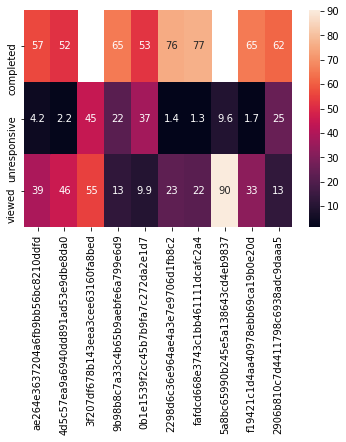

In [9]:
overall_perc = profile[relevant_columns].mask(lambda x: x.eq('not received')).apply(pd.value_counts, normalize=True).mul(100).round(4)
sns.heatmap(overall_perc, annot=True)

We can see that most customers view or/and complete an offer. Only a minority does not respond to an offer at all. This has to be kept in mind for the machine learning modell, we we should not let fool us by a high accuracy of a model, but always check for the accuracy of the minority class.

We also have to check the distribution of the sociodemographic variables we want to consider eventually in a model.

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-10-96f31c4d9e9c>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


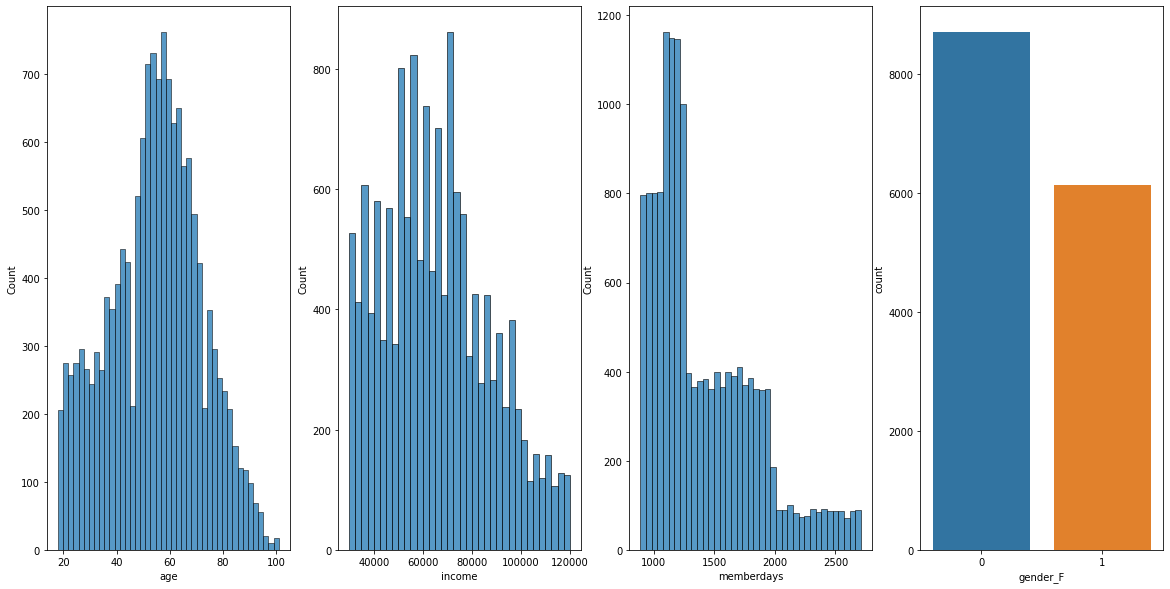

In [10]:
fig, ax =plt.subplots(1,4,figsize=(20,10))
sns.histplot(profile["age"], ax=ax[0])
sns.histplot(profile["income"], ax=ax[1])
sns.histplot(profile["memberdays"], ax=ax[2])
sns.countplot(profile["gender_F"], ax=ax[3])
fig.show()

<ul>
<li>Age: Follows a normal distribution, like the population in western countries</li>
<li>Income: Is skewed, we can see that only few people learn more than 100k</li>
<li>Memberdays: We can see that most of the people are relatively new (and that they program was carriet out 3 years ago</li>
<li>Gender: We have got more males than females. Only a few people indicated "other"</li>   
</ul>

Now we take a closer look at the behavior of the individuals by including the socio-demographic variables in the analysis. Therefore we create a list of dataframes for each offer id.

In [11]:
income_list = create_dflist(profile, relevant_columns, "income_cat")
age_list = create_dflist(profile, relevant_columns, "age_cat")
gender_list = create_dflist(profile, relevant_columns, "gender_M")
spendings_list = create_dflist(profile, relevant_columns, "spendings_cat")

We can run the `plot_dflist` function over all lists of dataframes. The grid parameter allows to display every plot every DataFrame seperately.

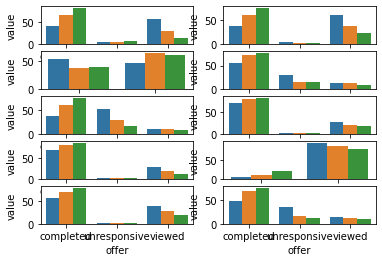

<Figure size 720x576 with 0 Axes>

In [12]:
plot_dflist(income_list, hue_var="income_cat")

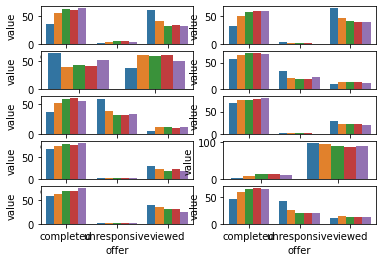

<Figure size 720x576 with 0 Axes>

In [13]:
plot_dflist(age_list, hue_var="age_cat")

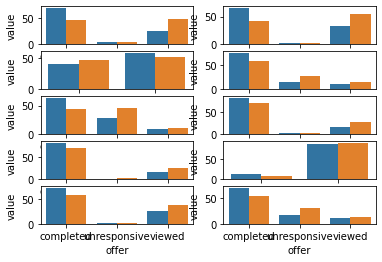

<Figure size 720x576 with 0 Axes>

In [14]:
plot_dflist(gender_list, hue_var="gender_M")

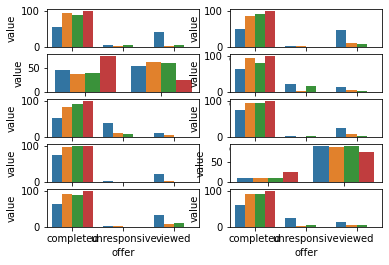

<Figure size 720x576 with 0 Axes>

In [15]:
plot_dflist(spendings_list, hue_var="spendings_cat")

## Discussion of the plots
<ul>
<li>Income: We can see a trend that the lowest income category tends to complete an offer overall far less than the other groups. For the informational types this is however different.</li>
<li>Age: Younger people tend to respond less to most offers except for informational offers</li>
<li>Gender: For most offers, males tend to complete the offers more often. Interestingly the unresponsive rate differs here from offer to offer. For offer 10 for example, women are more unresponsive, for offer 1 males tend to be slightly more responsive</li> 
<li>Overall spendings: It´s not a suprise that people who don´t spend any money on starbucks products, more do not complete the offers. For the informational offers, it is interested that offer 3 was so often not viewed by people who spend a lot of money </li>   
</ul>

# Modelbuilding
Our next step is to try to predict in which of the 4 categories a person will be. Especially the "unreponsive" category is interesting from a business perspective, because Starbucks could save the advertising budget here. Another interesting group is the group which completes the offers but would buy products anyway. The rewards could be saved in this case. But this point might be a bit too short and isolated. The rewards can have an effect on sympathy towards the brand and make the person spend more in general. An isolated and purely financial approach could be detrimental to the business. 
Points to consider in model building: 
- The machine learning model will have difficulty predicting unresponsive due to the very small number of cases, as the socio-demographic variables do not separate extremely sharply and thus will tend to predict the majority class. 
- To overcome the underrepresentation of "unresponsive", we will perform a SMOTE oversampling. 
- We compare multiple algorithms, and take the algorithm with the best f1-scores.

Best model gbc with f-score: 0.5746258309624455
Best model rf with f-score: 0.5522252341716095
Best model rf with f-score: 0.6741594793133636
Best model gbc with f-score: 0.5594472660345177
Best model rf with f-score: 0.6432539275194599
Best model rf with f-score: 0.5176287178502248
Best model rf with f-score: 0.5449410470295458
Best model gbc with f-score: 0.5807976889917452
Best model rf with f-score: 0.5187753665860441
Best model gbc with f-score: 0.6107229862149911


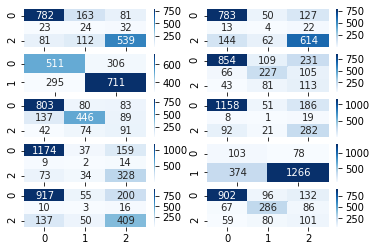

<Figure size 720x576 with 0 Axes>

In [16]:
predictions = []
for col in relevant_columns:
    f1score, y_pred, cm = use_best_model(profile, col, oversampling=True)
    predictions.append(cm)
    
fig, axes = plt.subplots(ncols=2, nrows=5)
for i, ax in zip(range(len(predictions)), axes.flat):
    plot = sns.heatmap(data=predictions[i], ax=ax, annot=True, cmap='Blues', fmt='g')
plt.figure(figsize=(10,8))
plt.show()

### Resume for the classification problem
We can clearly see that the model has problems to predict the correct classes and that the model has the biggest problem to predict the minority class, despite the SMOTE oversampling. We can clearly see that the sociodemographic variables can be used to make predictions about the behaviour, but to predict unresponsive people is quite difficult.

# Spendings Analysis
We can assume that sociodemographic variables also can an impact the spendings behaviour. So the first step is do perform an exploratory data analysis.

<ipython-input-17-4a52a8bbd262>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


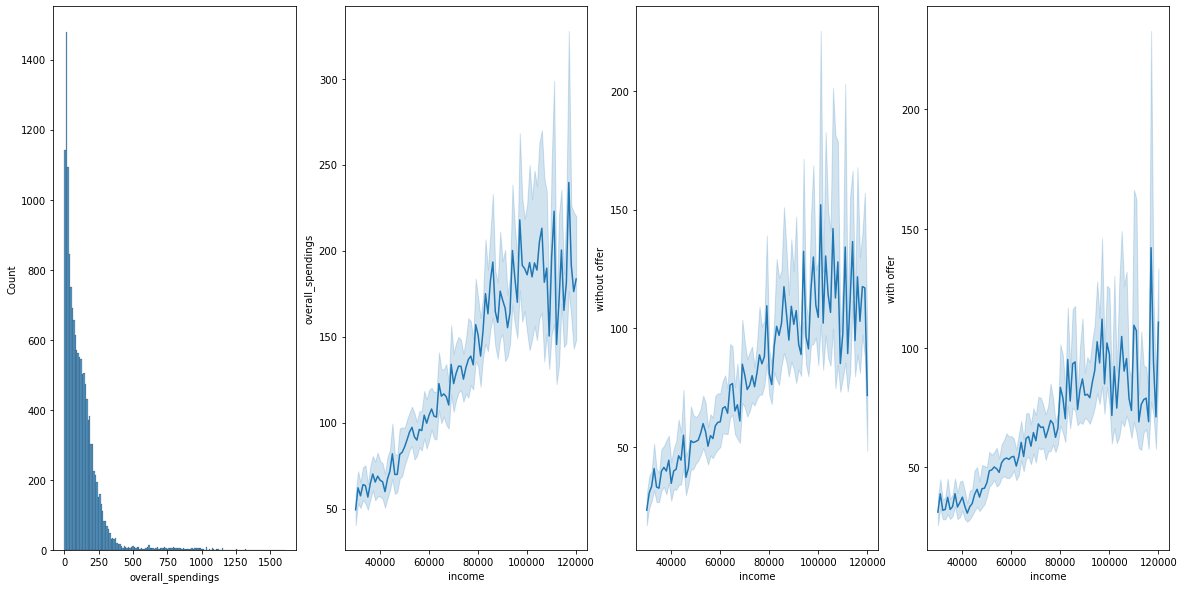

In [17]:
overall_spendings = profile[["income", "overall_spendings"]]
without_offer = profile[["income", "without offer"]].dropna().astype("int64")
with_offer = profile[["income", "with offer"]].dropna().astype("int64")

fig, ax =plt.subplots(1,4,figsize=(20,10))
sns.histplot(profile, x="overall_spendings", ax=ax[0])
sns.lineplot(data=overall_spendings, x="income", y="overall_spendings", ax=ax[1])
sns.lineplot(data=without_offer, x="income", y="without offer", ax=ax[2])
sns.lineplot(data=with_offer, x="income", y="with offer", ax=ax[3])
fig.show()

Spendings are skewed and some people even spend 0 in the offer time. On the other hand we have few people who spend a lot of money in that timeframe. The income seems to have a high impact on the spendings behaviour, but there is no obvious difference between people who spend their money with an offer and without an offer. Thats why we only take "overall_spendings" into consideration for a prediction (and further EDA)

**Important**: Due to it´s distribution of the overall_spendings variable, we should transform the dataset to make it easier for the model to predict the values. We use the `TransformedTargetRegressor` class to archieve this.

<ipython-input-18-7daa3769b3de>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


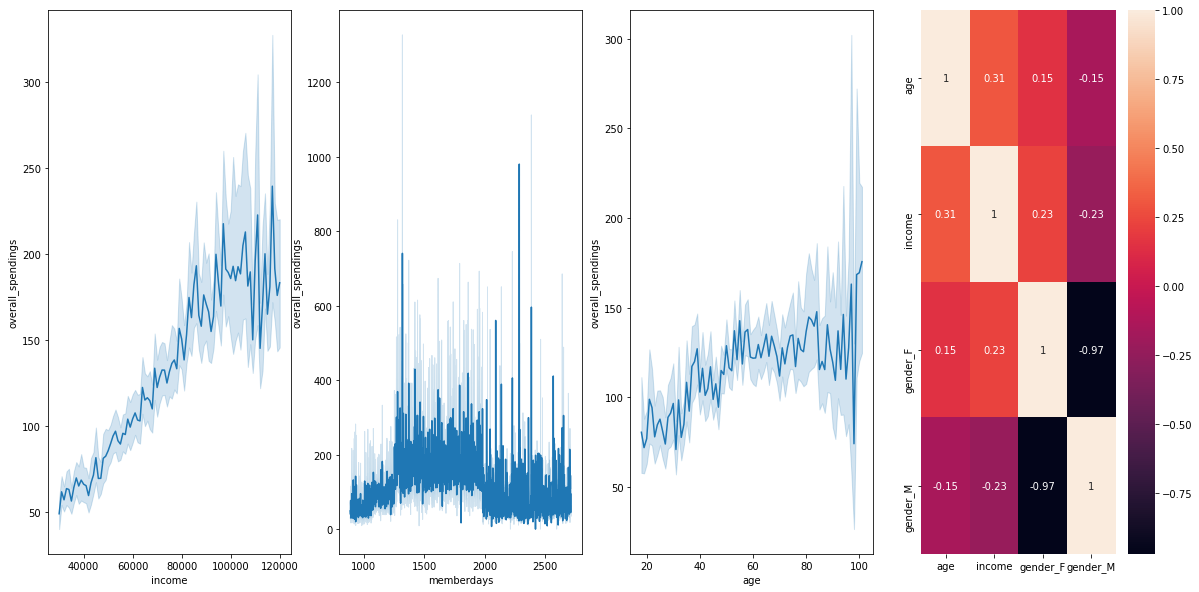

In [18]:
fig, ax =plt.subplots(1,4,figsize=(20,10))
sns.lineplot(data=profile, x="income", y="overall_spendings", ax=ax[0])
sns.lineplot(data=profile, x="memberdays", y="overall_spendings", ax=ax[1])
sns.lineplot(data=profile, x="age", y="overall_spendings", ax=ax[2])
sns.heatmap(profile[["age", "income", "gender_F", "gender_M"]].corr(), annot=True, ax=ax[3])
fig.show()

Besides income, age is also taking showing a visible trend, even though lower than the income variable (correlation between age and income is 0.31). The membersdays show a spike the middle area between ~1200 and ~2000. In the groups who are members for a longer time, we can assume that some of them are already inactive.

In [20]:
all_df, mse_all = create_scatter_df(profile, float("inf"))
df_500, mse_500 = create_scatter_df(profile, 500)
df_300, mse_300 = create_scatter_df(profile, 300)

print(mse_all / len(all_df))
print(mse_500 / len(df_500))
print(mse_300 / len(df_300))

3.840040431234994
1.5348335313537291
1.176322206836027


C:\Users\User\Desktop\Udacity\helper.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df[["age", "income", "memberdays"]] = scaler.fit_transform(
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\User\Desktop\Udacity\helper.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

<ipython-input-21-28e638bf5a4d>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


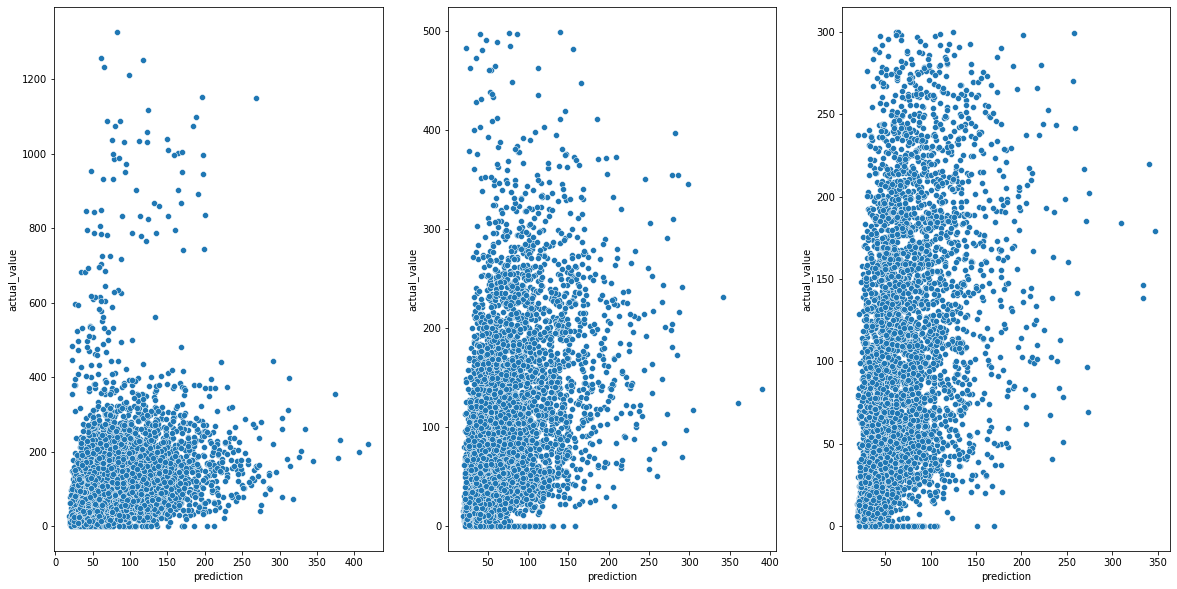

In [21]:
fig, ax =plt.subplots(1,3,figsize=(20,10))
sns.scatterplot(data=all_df, y="actual_value", x="prediction", ax=ax[0])
sns.scatterplot(data=df_500, y="actual_value", x="prediction", ax=ax[1])
sns.scatterplot(data=df_300, y="actual_value", x="prediction", ax=ax[2])
fig.show()

In [22]:
print(all_df["actual_value"].sum() / all_df["prediction"].sum())
print(df_500["actual_value"].sum() / df_500["prediction"].sum())
print(df_300["actual_value"].sum() / df_300["prediction"].sum())

1.5006591803172955
1.3871208890582292
1.3941049235845313


We have three different models now and we can see that every model underestimates the actual value. The worst model is the one, which keeps all outliers in the dataset. The independent variables are not separable enough to predict these outliers. The models with a lower threshold produce better results. Model 2 with a threshold seems to perform best, but I would still not consider the results to be a great model.

### Conclusion
I wanted to answer two questions in this project that dealt with customer behavior:
1. which customers behave how with which offer?
2. are there customers who don't spend any money anyway or who spend a lot of money without offers?

1. Answer: For the first question, a model was developed that allows multiclass prediction. A major difficulty here was that the classes were very unevenly distributed and "unresponsive" was strongly underrepresented in most offers. The models managed quite well to predict the majority classes, but whether customers would not respond to the offers in the first place was not something that could be satisfactorily predicted. Unfortunately, the other classes were not nearly as relevant, as can be seen from the answer to the second question

2. Answer:  The problem with this question was that there was not much difference between spending without and with the prospect of a reward. Spending behavior is strongly influenced by one's income, while the rest of the socio-demographic variables tend to have less of an influence. 

Potential improvement: Because multiple models were trained, cross-validation and hyperparameter tuning were not used due to training time. If these models were used in a production system or for real business decisions, this would be necessary in any case.

Unresolved issues: The findings of the experiment raise some questions that could not be resolved here due to the data situation. For example, it stands to reason that purchases with a reward in sight could also lead to this reward having a positive effect even after the purchase, and the person might continue to shop at Starbucks. Unmeasured values such as the perceived esteem as a customer can also have lasting positive effects. 
From a research perspective, it would make sense to have access to the data before the offers in order to measure differences here. It would also make sense to conduct this study again to see how robust the results are and whether spending behavior is not driven more strongly by other factors. 


